In [956]:
#!pip install xlwt

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [876]:
ForColab = False

In [877]:
if ForColab:
    !pip install wget
    import plotly.io as pio
    pio.renderers.default = 'colab'
else:
    print("Working local")

Working local


In [878]:
#
# Based on the SEIR-HCD model code from kaggle, I have added the online data for the world,
# one can choose which country they want, model to use and the date to use as initial start day
#

In [879]:
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
         'figure.max_open_warning': 0}
         
plt.rcParams.update(params)

In [1096]:
from datetime import datetime, timedelta
import os
from pathlib import Path

import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
    
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize,curve_fit

from sklearn.metrics import mean_squared_log_error, mean_squared_error

from PIL import Image

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)



Parameters used in the model
R_t = reproduction number at time t. Typical 3.6* at t=0

Transition times

- T_inc = average incubation period. Typical 5.6* days
- T_inf = average infectious period. Typical 2.9 days
- T_hosp = average time a patient is in hospital before either recovering or becoming critical. Typical 4 days
- T_crit = average time a patient is in a critical state (either recover or die). Typical 14 days

Fractions These constants are likely to be age specific (hence the subscript a):

- m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)
- c_a = fraction of severe cases that turn critical. Assumed 10%
- f_a = fraction of critical cases that are fatal. Assumed 30%
- *Averages taken from https://www.kaggle.com/covid-19-contributions

    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Reproduction number
    :param t_inc: Average incubation period. Default 5.2 days
    :param t_inf: Average infectious period. Default 2.9 days
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical. Default 4 days
    :param t_crit: Average time a patient is in a critical state (either recover or die). Default 14 days
    :param m_a: Fraction of infections that are asymptomatic or mild. Default 0.8
    :param c_a: Fraction of severe cases that turn critical. Default 0.1
    :param f_a: Fraction of critical cases that are fatal. Default 0.3
    :return:

In [881]:
# Susceptible equation
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S


# Exposed equation
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)


# Infected equation
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)


# Hospialized equation
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a):
    return ((1 - m_a) * (I / t_inf)) + ((1 - f_a) * C / t_crit) - (H / t_hosp)


# Critical equation
def dC_dt(H, C, t_hosp, t_crit, c_a):
    return (c_a * H / t_hosp) - (C / t_crit)


# Recovered equation
def dR_dt(I, H, t_inf, t_hosp, m_a, c_a):
    return (m_a * I / t_inf) + (1 - c_a) * (H / t_hosp)


# Deaths equation
def dD_dt(C, t_crit, f_a):
    return f_a * C / t_crit


def SEIR_HCD_model(t, y, R_t, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
    """

    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Reproduction number
    :param t_inc: Average incubation period. Default 5.2 days
    :param t_inf: Average infectious period. Default 2.9 days
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical. Default 4 days
    :param t_crit: Average time a patient is in a critical state (either recover or die). Default 14 days
    :param m_a: Fraction of infections that are asymptomatic or mild. Default 0.8
    :param c_a: Fraction of severe cases that turn critical. Default 0.1
    :param f_a: Fraction of critical cases that are fatal. Default 0.3
    :return:
    """
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t
        
    S, E, I, R, H, C, D = y
    
    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, m_a, c_a)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a)
    C_out = dC_dt(H, C, t_hosp, t_crit, c_a)
    D_out = dD_dt(C, t_crit, f_a)
    
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

In [882]:
def plot_model(solution, TotalPopulation, ICUHospital, title='SEIR+HCD model'):
    
    if TotalPopulation > 0:
        
        Population = True
        sus, exp, inf, rec, hosp, crit, death = solution.y*TotalPopulation
        cases = inf + rec + hosp + crit + death
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
        fig.suptitle(title)

        ax1.plot(sus, 'tab:blue', label='Susceptible');
        ax1.plot(exp, 'tab:orange', label='Exposed');
        ax1.plot(inf, 'tab:red', label='Infected');
        ax1.plot(rec, 'tab:green', label='Recovered');
        ax1.plot(hosp, 'tab:purple', label='Hospitalised');
        ax1.plot(crit, 'tab:brown', label='Critical');
        ax1.plot(death, 'tab:cyan', label='Deceased');
        ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
                   label="Mean ICU beds")

        #y1 = ICUHospital[1][0]
        #y2 = ICUHospital[1][1]
        #ax1.axhspan(y1, y2, facecolor='k', alpha=0.5)
        
        ax1.semilogy()

        ax1.set_xlabel("Days", fontsize=10);
        ax1.legend(loc='best');

        ax2.plot(cases, 'tab:red', label='Cases');    
        ax2.set_xlabel("Days", fontsize=10);
        ax2.semilogy()

        ax3 = ax2.twinx()
        ax3.plot(death, 'tab:cyan', label='Deceased');    
        ax3.set_xlabel("Days", fontsize=10);
        ax3.semilogy()

        ax1.set_ylabel("No of population", fontsize=10);
        ax2.set_ylabel("No of population (Cases)", fontsize=10, color='tab:red');
        ax3.set_ylabel("No of population (Fatalities)", fontsize=10, color='tab:cyan');
        
    else:
        Population = False
        sus, exp, inf, rec, hosp, crit, death = solution.y
        cases = inf + rec + hosp + crit + death
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
        fig.suptitle(title)

        ax1.plot(sus, 'tab:blue', label='Susceptible');
        ax1.plot(exp, 'tab:orange', label='Exposed');
        ax1.plot(inf, 'tab:red', label='Infected');
        ax1.plot(rec, 'tab:green', label='Recovered');
        ax1.plot(hosp, 'tab:purple', label='Hospitalised');
        ax1.plot(crit, 'tab:brown', label='Critical');
        ax1.plot(death, 'tab:cyan', label='Deceased');
        #ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
        #           label="Mean ICU beds")
        #y1 = ICUHospital[1][0]
        #y2 = ICUHospital[1][1]
        #ax1.axhspan(y1, y2, facecolor='k', alpha=0.5)
        
        ax1.set_xlabel("Days", fontsize=10);
        ax1.legend(loc='best');

        ax2.plot(cases, 'tab:red', label='Cases');    
        ax2.set_xlabel("Days", fontsize=10);

        ax3 = ax2.twinx()
        ax3.plot(death, 'tab:cyan', label='Deceased');    
        ax3.set_xlabel("Days", fontsize=10);
        
        ax1.set_ylabel("Fraction of population", fontsize=10);
        ax2.set_ylabel("Fraction of population (Cases)", fontsize=10, color='tab:red');
        ax3.set_ylabel("Fraction of population (Fatalities)", fontsize=10, color='tab:cyan');
        


    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),ncol=3, fancybox=True, shadow=True)

# Data for SA

In [883]:
SAPopulation = 59156682
#DateLockDownStart = '2020-03-27'

In [885]:
ToUpdateSAData = input("Do we update datasets [y/n] ")

Do we update datasets [y/n] y


## Hospital data

In [886]:
def get_sa_hospital(ToUpdateSAData):
    if ToUpdateSAData.lower()=='y':
        url= "https://raw.githubusercontent.com/dsfsi/covid19za/Hospital_Data/data/health_system_za_public_hospitals_extended_details.csv"
        HospitalDf = pd.read_csv(wget.download(url))
    else:
        HospitalDf = pd.read_csv('health_system_za_public_hospitals_extended_details.csv')
    HospitalWithICU = HospitalDf.loc[np.where(HospitalDf.speciality_services.str.contains('intensive care') == True)]

    print(f"Mean Capacity \n{HospitalWithICU[['minimum_capacity','maximum_capacity']].mean()} \n Total Capacity \n{HospitalWithICU[['minimum_capacity','maximum_capacity']].sum()}")
    
    return(HospitalWithICU[['minimum_capacity','maximum_capacity']].mean(),
          HospitalWithICU[['minimum_capacity','maximum_capacity']].sum())

In [887]:
SAHospital = get_sa_hospital('y')

Mean Capacity 
minimum_capacity    371.428571
maximum_capacity    771.428571
dtype: float64 
 Total Capacity 
minimum_capacity     7800.0
maximum_capacity    16200.0
dtype: float64


In [888]:
MeanTotalBed = np.mean([SAHospital[1][0],SAHospital[1][1]])

# Getting daily data for the world 

In [889]:
ToUpdateCOVID = input("To update COVID-19 csv data [y/n]")

To update COVID-19 csv data [y/n]y


In [890]:
def get_world_dataframe(ToUpdate):
    #
    # data from https://www.worldometers.info/coronavirus/country/south-africa/
    #
    # Based on current data for e.g. SA
    #
    ### Include the data to extract the stats for particular country 
    ### Put country's params in a dict ?
    #
    if ToUpdateCOVID.lower()=='y':
        print("Updating csv")
        url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 
        Confirmed_data = pd.read_csv(wget.download(url))
        
        url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
        Death_data = pd.read_csv(wget.download(url))

        url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series//time_series_covid19_recovered_global.csv"
        Recovered_data = pd.read_csv(wget.download(url))

    else:
        print("Will be loading local dataset")
        Globfilename = "/Users/nadeem/GitHub/COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
        Confirmed_data = pd.read_csv(Globfilename)

        Deathfilename = "/Users/nadeem/GitHub/COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
        Death_data = pd.read_csv(Deathfilename)

        Deathfilename = "/Users/nadeem/GitHub/COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
        Recovered_data = pd.read_csv(Deathfilename)


    dates = Confirmed_data.columns[4:]
    Confirmed_data_long = Confirmed_data.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                                value_vars=dates, var_name='Date', value_name='Confirmed')
    Confirmed_data_long["Date"] = pd.to_datetime(Confirmed_data_long.Date)
    Confirmed_data_long.index = Confirmed_data_long["Date"]

    Confirmed_data_long.columns

    dates = Death_data.columns[4:]
    Death_data_long = Death_data.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                                value_vars=dates, var_name='Date', value_name='Dead')
    Death_data_long["Date"] = pd.to_datetime(Death_data_long.Date)
    Death_data_long.index = Death_data_long["Date"]

    dates = Recovered_data.columns[4:]
    Recovered_data_long = Recovered_data.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                                value_vars=dates, var_name='Date', value_name='Recovered')
    Recovered_data_long["Date"] = pd.to_datetime(Recovered_data_long.Date)
    Recovered_data_long.index = Recovered_data_long["Date"]



    df = pd.concat([Confirmed_data_long,Recovered_data_long,Death_data_long],join='outer')
    df.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'DateReported', 'Confirmed','Recovered', 'Dead']
    
    return(Confirmed_data_long,Death_data_long, Recovered_data_long,df)

In [891]:
ConfirmedDf, DeadDf, RecoveredDf, df = get_world_dataframe('y')

Updating csv


In [892]:
len(df)

86240

In [893]:
ToPlot = False

In [894]:
countries = df["Country/Region"].unique()
df_by_date = df.groupby("Date").sum()
last_day = df_by_date.iloc[-1]
pre_last_day = df_by_date.iloc[-2]
total_infected = last_day["Confirmed"]
total_deaths = last_day["Dead"]
total_recoveries = pre_last_day["Recovered"]

infected_timeline = df_by_date["Confirmed"]
death_timeline = df_by_date["Dead"]
recovery_timeline = df_by_date["Recovered"][:-1]

print("[!] GENERAL STATISTICS")
print("[-] Number of infected countries: {}".format(len(countries)))
print("[-] Total number of infected: {}".format(total_infected))

print("[-] Total number of deaths: {}".format(total_deaths))

print("[-] Total number of recoveries: {}".format(total_recoveries))

if ToPlot:
    infected_timeline.iplot()
    death_timeline.iplot()
    recovery_timeline.iplot()

[!] GENERAL STATISTICS
[-] Number of infected countries: 187
[-] Total number of infected: 4101699.0
[-] Total number of deaths: 282709.0
[-] Total number of recoveries: 1375624.0


## Plotting for South Africa here

In [895]:
DfSA = df[df['Country/Region'] == 'South Africa']
SA_last_date = DfSA.index[-1].date().strftime("%Y-%m-%d")

SA_by_date = DfSA.groupby("DateReported").sum()
SA_last_day = DfSA.iloc[-1]
SA_pre_last_day = DfSA.iloc[-2]
SAtotal_infected = DfSA[DfSA["DateReported"]== SA_last_date]["Confirmed"][0]
SAtotal_deaths = DfSA[DfSA["DateReported"]== SA_last_date]["Dead"][2]
SAtotal_recoveries = DfSA[DfSA["DateReported"]== SA_last_date]["Recovered"][1]

SAinfected_timeline = SA_by_date["Confirmed"]
SAdeath_timeline = SA_by_date["Dead"]
SArecovery_timeline = SA_by_date["Recovered"][:-1]



print(f"[!] GENERAL STATISTICS as at {SA_last_date}")
#print("[-] Number of infected countries: {}".format(len(countries)))
print("[-] Total number of infected: {}".format(SAtotal_infected))

print("[-] Total number of deaths: {}".format(SAtotal_deaths))

print("[-] Total number of recoveries: {}".format(SAtotal_recoveries))

if ToPlot:
    SAdeath_timeline.iplot(interpolation="spline")
    SAinfected_timeline.iplot(interpolation="spline")
    SArecovery_timeline.iplot(interpolation="spline")

[!] GENERAL STATISTICS as at 2020-05-10
[-] Total number of infected: 10015.0
[-] Total number of deaths: 194.0
[-] Total number of recoveries: 4173.0


# Put fit to the various curves

In [896]:
# Calculate the doubling days

In [897]:
#SAinfected_timeline

## Getting SA province data 

In [1489]:
def get_SA_province(ToUpdateSAProvince):
    '''
    This function will get the SA provincial confirmed and cases as function of date
    It also has the total that should agree with the reported worldodometer confirmed cases
    Input:
        Take a y or n - whether to update the dataset or not
    Output:
        Returns the SA province confirmed dataframe
    '''
    import pandas as pd
    import wget
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context

    if ToUpdateSAProvince.lower() =='y':
        
        print("updating data")
        ConfirmedURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
        SAProvinConfirmed = pd.read_csv(wget.download(ConfirmedURL))
        DeathURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"
        SAProvinDead = pd.read_csv(wget.download(DeathURL))
        
    else:
        print("Reading local file... Please check data is uptodate")
        SAProvinConfirmed  = pd.read_csv("covid19za_provincial_cumulative_timeline_confirmed.csv")
        SAProvinDead = pd.read_csv("covid19za_provincial_cumulative_timeline_deaths.csv")
        print(f"Note: File was last updated on {SAProvinConfirmed['date'].values[-1]}")
    #
    # Drop the unwanted column
    #
    if 'YYYYMMDD' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='YYYYMMDD', inplace = True)
        SAProvinDead.drop(columns='YYYYMMDD', inplace = True)
    #
    # Drop the source of information
    #
    if 'source' in SAProvinConfirmed.columns:
        SAProvinConfirmed.drop(columns='source', inplace = True)
        SAProvinDead.drop(columns='source', inplace = True)
    #
    # Make the date the index
    #
    SAProvinConfirmed["date"] = pd.to_datetime(SAProvinConfirmed.date, format='%d-%m-%Y')
    SAProvinConfirmed.index = SAProvinConfirmed["date"]
    
    SAProvinDead["date"] = pd.to_datetime(SAProvinDead.date, format='%d-%m-%Y')
    SAProvinDead.index = SAProvinDead["date"]
    #
    # Deleting the date column now
    #
    SAProvinConfirmed.drop(columns='date', inplace = True)
    SAProvinDead.drop(columns='date', inplace = True)
    #
    # Renaming the Total column to Confirmed
    #
    SAProvinConfirmed = SAProvinConfirmed.rename(columns={'total': 'Confirmed'})
    SAProvinDead = SAProvinDead.rename(columns={'total': 'Confirmed'})
    #
    #
    #

    return(SAProvinConfirmed,SAProvinDead)

In [1481]:
ProvinConf, ProvinDead = get_SA_province('y') 

updating data


In [1487]:
ProvinConf.head()

,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Confirmed
date,,,,,,,,,,,
2020-03-05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2020-03-07,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2020-03-08,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2020-03-09,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2020-03-11,0.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,13


In [1488]:
ProvinDead.head()

,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Confirmed
date,,,,,,,,,,,
2020-03-27,0,0,0,0,0,0,0,0,1,0,1
2020-03-28,0,0,0,1,0,0,0,0,1,0,2
2020-03-30,0,1,0,1,0,0,0,0,1,0,3
2020-03-31,0,1,1,2,0,0,0,0,1,0,5
2020-04-03,0,1,1,6,0,0,0,0,1,0,9


In [902]:
#
# Validation test to check world dataset and local dataset aggrees on selected date
#

MyDate = input('Date for checking dataset YYYY-MM-DD: ')

if SAtotal_infected == SAProvinConfirmed[(SAProvinConfirmed.index == MyDate)].Confirmed.values:
    print(f"No prob in dataset for {MyDate}")
else:
    print("Maybe some data issue")

Date for checking dataset YYYY-MM-DD: 2020-05-10
No prob in dataset for 2020-05-10


In [903]:
SAProvinConfirmed.iplot(theme="white",xTitle = "dates",yTitle="No of confirmed case",width=3,
                        title=f"SA provincial distribution as at {SAProvinConfirmed.index[-1].date()}")


### Doing some prediction using fbprophet

In [904]:
def prophet_forecast(mydate,mydata):
    '''
    This function will use fbprophet to forecast the cases in 30 days
    Input: Date and ycolumn
    Output: returns a forecast dataframe
    '''
    from fbprophet import Prophet
    from fbprophet.plot import plot_plotly, add_changepoints_to_plot

    data = pd.DataFrame({'ds': mydate, 'y': mydata})

    prop=Prophet(changepoint_range=0.9)
    prop.fit(data)
    future=prop.make_future_dataframe(periods=30)
    prop_forecast=prop.predict(future)
    forecast = prop_forecast[['ds','yhat']].tail(30)

    fig = plot_plotly(prop, prop_forecast)
    fig = prop.plot(prop_forecast,xlabel='Date',ylabel='No of Cases')
    
    return(prop_forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


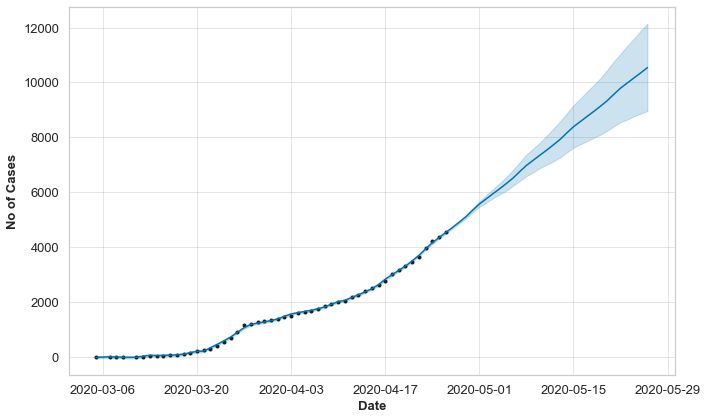

In [905]:
DateToUse = "2020-04-27"
mydata = SAProvinConfirmed[SAProvinConfirmed.index<DateToUse]['Confirmed'].values.tolist()
mydate = SAProvinConfirmed[SAProvinConfirmed.index<DateToUse].index.values

ProphetDF = prophet_forecast(mydate,mydata)

#### Forecasting WC confirmed cases.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


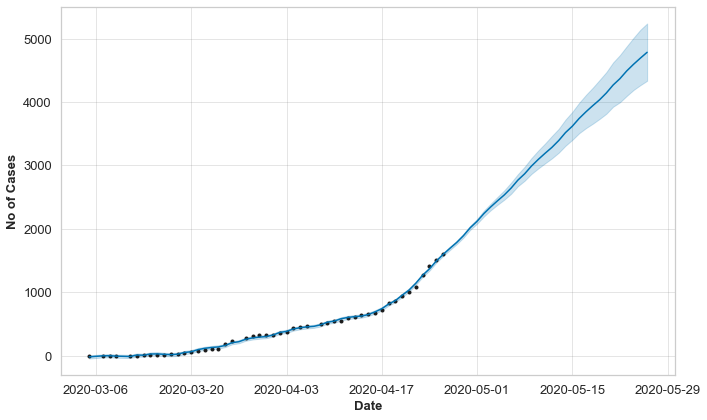

In [906]:

mydata = SAProvinConfirmed[SAProvinConfirmed.index<DateToUse]['WC'].values.tolist()
mydate = SAProvinConfirmed[SAProvinConfirmed.index<DateToUse].index.values
ProphetDFWC = prophet_forecast(mydate,mydata)

#### Forecasting the death numbers

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


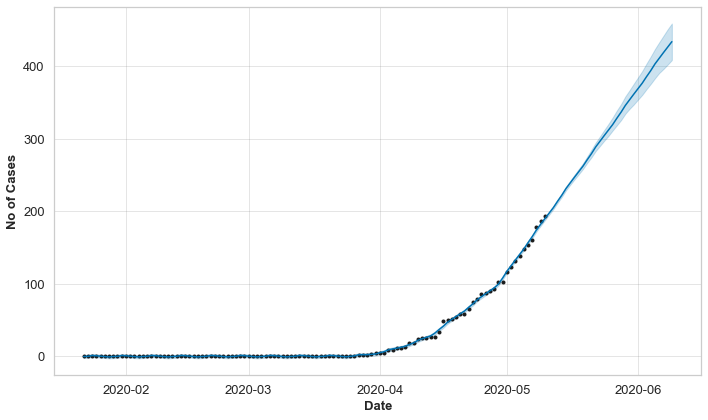

In [907]:
mydata = SAdeath_timeline.values.tolist()
mydate = SAdeath_timeline.index.values
ProphetDFDeath = prophet_forecast(mydate,mydata)

# Parameters estimates for other models

## Location of various parameters as per Midas 

### https://github.com/midas-network/COVID-19/blob/master/parameter_estimates/2019_novel_coronavirus/estimates.csv
### Check above link for updated parameters

Paramters used:

- Average incubation period, t_inc
- Average infection period, t_inf
- Average hospitalization period, t_hosp
- Average critital period, t_crit
- The fraction of mild/asymptomatic cases, m_a
- The fraction of severe cases that turn critical, c_a
- The fraction of critical cases that result in a fatality, f_a
- Reproduction number, R_0 or R_t

In [1373]:
#
# This is not working properly 
#

ToUpdate = input("To update data [y/n] ")

url = "https://raw.githubusercontent.com/midas-network/COVID-19/master/parameter_estimates/2019_novel_coronavirus/estimates.csv"
if ToUpdate.lower()=='y':
    ParamEstimates = pd.read_csv(wget.download(url))
else:
    ParamEstimates = pd.read_csv("estimates.csv")

To update data [y/n] y


In [1374]:
ParamEstimates.columns

Index(['id', 'peer_review', 'peer_review_location', 'name', 'abbreviation',
       'units', 'country', 'location_name', 'location_type', 'start_date',
       'end_date', 'value_type', 'value', 'uncertainty_type', 'lower_bound',
       'upper_bound', 'population', 'age_range', 'method_description',
       'data_description', 'data_URL', 'date_publication', 'title_publication',
       'type_publication', 'authors', 'publication_URL', 'entry_date',
       'entry_person', 'entry_email'],
      dtype='object')

In [1375]:
ParamEstimates['peer_review'].unique()

array([nan, 'positive', 'negative', 'postitive'], dtype=object)

In [1376]:
ParamEstimates['peer_review']  = ParamEstimates['peer_review'].replace({'postitive':'positive'})

In [1377]:
ParamEstimates['peer_review']  = ParamEstimates['peer_review'].replace({np.nan:'Not_Available'})

In [1378]:
ParamEstimates.to_excel("estimates.xls")

In [1379]:
ValidParams = ParamEstimates['abbreviation'].unique()

In [1380]:
PeerRevDF['name'].unique()

array(['basic reproduction number',
       'proportion of hospitalized cases that die', 'incubation period',
       'ascertainment rate', 'cumulative case count',
       'effective reproduction number', 'latent period',
       'transmission rate', 'reporting rate',
       'proportion of hospitalized cases on mechanical ventilation',
       'time from symptom onset to hospitalization',
       'time from hospitalization to mechanical ventilation',
       'proportion of ICU patients that die',
       'proportion of ICU cases on mechanical ventilation',
       'proportion of ICU cases on Extracorporeal Membrane Oxygenation (ECMO)',
       'duration of ICU stay',
       'proportion of hospitalized cases treated with antivirals',
       'proportion of hospitalized cases admitted to ICU',
       'proportion of hospitalized cases on Extracorporeal Membrane Oxygenation (ECMO)',
       'proportion of hospitalized cases treated with antibiotics',
       'proportion of infections acquired in hospi

In [1415]:
try:
    WhatToSearch = ParamEstimates[(ParamEstimates['abbreviation'] == 'R0') | 
                                   (ParamEstimates['name'] == 'basic reproduction number')]
except:
    WhatToSearch = ParamEstimates[(ParamEstimates['abbreviation'] == 'R0')]

In [1416]:
WhatToSearch['value'].replace({"Unspecified":np.nan},inplace=True)

WhatToSearch['value'].dropna(inplace=True)

print(WhatToSearch['country'].unique())
WhatToSearch[WhatToSearch['country'] == input("Enter country")]['value']
WhatToSearch.value

['China' 'Cruise Ship' 'Singapore' 'Iran' 'Japan' 'Afghanistan' 'Albania'
 'Algeria' 'Andorra' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahrain' 'Belgium' 'Bosnia and Herzegovina' 'Brazil'
 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Canada' 'Chile' 'Colombia'
 'Costa Rica' "Côte d'Ivoire" 'Croatia' 'Cyprus' 'Czech Republic'
 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt' 'Estonia'
 'Faroe Islands' 'Finland' 'France' 'Germany' 'Ghana' 'Greece' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jordan'
 'Kazakhstan' 'Korea' 'Kuwait' 'Latvia' 'Lebanon' 'Lithuania' 'Luxembourg'
 'Malaysia' 'Malta' 'Mexico' 'Moldova' 'Morocco' 'Netherlands'
 'New Zealand' 'North Macedonia' 'Norway' 'Oman' 'Pakistan' 'Panama'
 'Peru' 'Philippines' 'Poland' 'Portugal' 'Qatar' 'Réunion' 'Romania'
 'Russia' 'San Marino' 'Saudi Arabia' 'Senegal' 'Serbia' 'Slovakia'
 'Slovenia' 'South Africa' 'Spain' 'Sri Lanka' 'Sweden' 'Switzerland'
 'Thailand' 'The United Kingdo

3       0.3
4       2.2
5       2.6
6      2.24
19     1.48
       ... 
411       3
412     2.6
436    2.55
473     5.7
537     3.6
Name: value, Length: 139, dtype: object

In [1417]:
try:
    WhatToSearch = ParamEstimates[(ParamEstimates['abbreviation'] == 'serial interval') | 
                                   (ParamEstimates['name'] == 'serial interval')]
except:
    WhatToSearch = ParamEstimates[(ParamEstimates['name'] == 'serial interval')]

In [1424]:
WhatToSearch.columns

Index(['id', 'peer_review', 'peer_review_location', 'name', 'abbreviation',
       'units', 'country', 'location_name', 'location_type', 'start_date',
       'end_date', 'value_type', 'value', 'uncertainty_type', 'lower_bound',
       'upper_bound', 'population', 'age_range', 'method_description',
       'data_description', 'data_URL', 'date_publication', 'title_publication',
       'type_publication', 'authors', 'publication_URL', 'entry_date',
       'entry_person', 'entry_email'],
      dtype='object')

In [1432]:
WhatToSearch['name'].values

array(['serial interval', 'serial interval', 'serial interval',
       'serial interval', 'serial interval', 'serial interval',
       'serial interval', 'serial interval', 'serial interval'],
      dtype=object)

In [1440]:
WhatToSearch['value'].replace({"Unspecified":np.nan},inplace=True)

WhatToSearch['value'].dropna(inplace=True)

print(WhatToSearch['country'].unique())
df = WhatToSearch[WhatToSearch['country'] == input("Enter country ")]#['name','abbreviation','units','country']



['Singapore' 'China' 'Italy']
Enter country China


KeyError: ('name', 'abbreviation', 'units', 'country')

In [1435]:
df

,name,abbreviation,units,country
name,NaN,NaN,NaN,NaN
abbreviation,NaN,NaN,NaN,NaN
units,NaN,NaN,NaN,NaN
country,NaN,NaN,NaN,NaN


In [917]:
def get_params(ParamEstimates, ColumnsToUse, ParamName):
    try:
        ParamName_nopeer = [np.float(ParamEstimates[(ParamEstimates[ColumnsToUse] == ParamName)]['lower_bound'].values[0]),
                            np.float(ParamEstimates[(ParamEstimates[ColumnsToUse] == ParamName)]['upper_bound'].values[0]),
                            np.float(ParamEstimates[(ParamEstimates[ColumnsToUse] == ParamName)]['value'].values[0])]

        ParamName_peer = [ParamEstimates[(ParamEstimates[ColumnsToUse] == ParamName) & 
                                         (ParamEstimates['peer_review'] == "positive")]['lower_bound'].values,
                          ParamEstimates[(ParamEstimates[ColumnsToUse] == ParamName) & 
                                         (ParamEstimates['peer_review'] == "positive")]['upper_bound'].values,
                          ParamEstimates[(ParamEstimates[ColumnsToUse] == ParamName) & 
                                         (ParamEstimates['peer_review'] == "positive")]['value'].values]
        if np.array(ParamName_peer).size == 0:
            print(ParamName_nopeer)
            ParamName = np.mean(np.array(ParamName_nopeer))
            print(f"Array is empty, will use non-peer reviewed {ParamName}")
            print(ParamEstimates[ParamEstimates[ColumnsToUse] == ParamName]['publication_URL'])
            ParamVal = "NaN"
        else:
            print(ParamName_peer)
            ParamVal = float(ParamName_peer[-1][1])
            print(f"\n \033[1m Using peer-reviewed mean value: {ParamVal}\033[0m")
            print(PeerRevDF[PeerRevDF[ColumnsToUse] == ParamName]['publication_URL'])
            
        return(ParamVal)
    except:
        print("something wrong in values")
        pass
    
   

In [918]:
ParamEstimates[(ParamEstimates['name'] == 'serial interval') & 
                                         (ParamEstimates['peer_review'] == "positive")]['lower_bound'].values

array(['1.3'], dtype=object)

In [919]:
ParamEstimates[(ParamEstimates['name'] == 'serial interval')]['value'].values

array(['4.56', '4.22', '5.21', '3.95', '6.3', '6.6', '4.95', '5.19',
       '5.1'], dtype=object)

In [920]:
ValidParams

array([nan, 'R0', 'k', 'CFR', 'RE', 'gamma', 'r', 'R', 'Rt', 'K', 'Rv',
       'Z', 'beta', 'alpha', 'IFR', 'Reff', 'X0', 'Xf', 'r0', 'rf'],
      dtype=object)

In [922]:

for Name in ValidParams:
    print(f"\033[1m Getting params: {Name} \033[0m ")
    if str(Name).lower() != 'nan':
        
        get_params(ParamEstimates,'abbreviation',Name)
        
    else:
        print("Not valid encountered")
        pass

 Getting params: nan  
Not valid encountered
 Getting params: R0  
[array(['0.17', '1.96', '3.8', '3.49'], dtype=object), array(['0.44', '2.55', '8.9', '3.84'], dtype=object), array(['0.3', '2.24', '5.7', '3.6'], dtype=object)]

  Using peer-reviewed mean value: 2.24
3      https://eurosurveillance.org/content/10.2807/1...
6      https://www.biorxiv.org/content/10.1101/2020.0...
473    https://wwwnc.cdc.gov/eid/article/26/7/20-0282...
537    https://www.pnas.org/content/early/2020/04/22/...
Name: publication_URL, dtype: object
 Getting params: k  
[0.014, 6.95, 0.54]
Array is empty, will use non-peer reviewed 2.5013333333333336
Series([], Name: publication_URL, dtype: object)
 Getting params: CFR  
something wrong in values
 Getting params: RE  
something wrong in values
 Getting params: gamma  
[2.9, 3.0, 2.94]
Array is empty, will use non-peer reviewed 2.9466666666666668
Series([], Name: publication_URL, dtype: object)
 Getting params: r  
[array(['0.21'], dtype=object), array(['0.29

In [923]:
!pwd

/Users/nadeem/GitHub/COVID-19


In [924]:
ParamEstimates[(ParamEstimates['name'].str.contains("time from"))]['name'].unique()

array(['time from symptom onset to isolation',
       'time from symptom onset to death',
       'time from symptom onset to hospitilization',
       'time from hospitilization to death',
       'time from hospitalization to recovery',
       'time from hospitalization to death',
       'time from symptom onset to reporting',
       'time from symptom onset to hospitalization',
       'time from symptom onset to recovery',
       'time from symptom onset to PCR confirmation',
       'time from hospitalization to mechanical ventilation',
       'time from symptom onset to Dyspena',
       'time from symptom onset to ARDS',
       'time from symptom onset to ICU admission'], dtype=object)

In [925]:
for Name in ParamEstimates[(ParamEstimates['name'].str.contains("time from"))]['name'].unique():
    print(f"\033[1m {Name}\033[0m \n")
    get_params(ParamEstimates,"name",Name)

 time from symptom onset to isolation 

something wrong in values
 time from symptom onset to death 

[array(['13.1'], dtype=object), array(['20.2'], dtype=object), array(['16.1'], dtype=object)]
something wrong in values
 time from symptom onset to hospitilization 

[1.6, 4.1, 2.7]
Array is empty, will use non-peer reviewed 2.7999999999999994
Series([], Name: publication_URL, dtype: object)
 time from hospitilization to death 

[6.4, 10.5, 8.3]
Array is empty, will use non-peer reviewed 8.4
Series([], Name: publication_URL, dtype: object)
 time from hospitalization to recovery 

[array(['9'], dtype=object), array(['17.3'], dtype=object), array(['11.5'], dtype=object)]
something wrong in values
 time from hospitalization to death 

[array(['8.7'], dtype=object), array(['14.9'], dtype=object), array(['11.2'], dtype=object)]
something wrong in values
 time from symptom onset to reporting 

[array(['1', '2', '1'], dtype=object), array(['18', '19.8', '12'], dtype=object), array(['7.4', '8.

In [926]:
SA_model

{'R_0': 9.0,
 'R_t': 1.2908002469590283,
 't_inc': 5.1,
 't_inf': 6.5,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.1,
 'f_a': 0.3}

In [927]:
Midas_model ={
    "R_0" : 2.24,
    "R_t" : 0.87, # since there is no peer reviewed R_t
    "t_inc" : 5.2,
    "t_inf" : 2.9,
    "t_hosp" : 4,
    "t_crit" : 14,
    "m_a" : 0.8,
    "c_a" : 0.1,
    "f_a" : 0.3
}

In [928]:
Midas_model

{'R_0': 2.24,
 'R_t': 0.87,
 't_inc': 5.2,
 't_inf': 2.9,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.1,
 'f_a': 0.3}

In [929]:
# From Imperial model

- R_0 = 2.4 # basic reproductive number
- t_incu = 5.1 # average incubation period
- t_infect = 6.5 # average infectious period
- t_hosp = 4 # time in hospital before transitioning to either critical or recovered
- t_crit = 10 # average time patient is critical before transition to recovered or dead

- ratio_mild = 0.80 # ratio of infections that are mild.
- ratio_unreported = 0.8 # ratio of total infections that are unreported due to lack of symptoms #5-80% https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
- ratio_asymptomatic = 0.96 # ratio of infections that are either mild or unreported, and may be symptomless (it's a bad variable name!)
- ratio_severe = 1 - ratio_mild
- ratio_crit = 0.20 # ratio of severe cases that become critical
- ratio_fatal = 0.40 # ratio of critical cases that result in death

In [930]:
Imperial_model ={
        # use parameters from the Imperial paper (https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)
        "R_0" : 2.4,
        "R_t" : 1.16,#0.7, # since there is no peer reviewed R_t
        "t_inc" : 5.1,
        "t_inf" : 6.5,
        "t_hosp" : 4,
        "t_crit" : 14,
        "m_a" : 0.8,
        "c_a" : 0.2,
        "f_a" : 0.4
}

In [931]:
Imperial_model

{'R_0': 2.4,
 'R_t': 1.16,
 't_inc': 5.1,
 't_inf': 6.5,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.2,
 'f_a': 0.4}

In [932]:
Kaggle_model ={
        "R_0" : 3.6,
        "R_t" : 0.7,
        "t_inc" : 5.6,
        "t_inf" : 2.9,
        "t_hosp" : 4,
        "t_crit" : 14,
        "m_a" : 0.8,
        "c_a" : 0.1,
        "f_a" : 0.3
}

# Calculating value of R_t

In [1499]:

def get_Rt(DFSeries):
    '''
    This function will calculate the value of Rt for a series.
    In order to calculate R0 we can adapt this 
    https://en.wikipedia.org/wiki/Basic_reproduction_number#Estimation_methods

    Reminder: Rt = R0 when no intervention has been applied and there is mixing
    
    usage get_Rt(pandas_series)
    
    Input:
        Take in a pandas series with time and value
    Output:
        Return the value of R0
    
    '''
    import numpy as np
    from scipy.optimize import minimize,curve_fit
    
    def fit_expo(x,y):   
        logParams   = np.polyfit(x, np.log(y), 1,w=np.sqrt(y))
        initParams  = (np.exp(logParams[1]), logParams[0])
        params      = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y, p0=initParams)    
        return params[0],params[1],initParams

    x = np.arange(len(DFSeries))
    y = list(DFSeries.values)
    LogisticFit = fit_expo(x,y)

    a = LogisticFit[0][0]
    b = LogisticFit[0][1] # This is also knonw as K from descriptio in Wikipedia
    #
    # The dooubling rate is given by T_d
    #
    T_d = np.log(2)/b 
    #
    # We will use the imperial value for tau
    #
    tau = 5.1 
    
    Rt = np.mean(np.exp(b*tau))

    
    return(Rt)

In [1500]:
ToFit = SAProvinConfirmed[SAProvinConfirmed.index < datetime.strptime('Mar 27 2020', '%b %d %Y') ]['Confirmed']


In [1502]:
get_Rt(ToFit)

3.9886984387357933

In [1493]:
#
# To calculate R_0 we need to take data before the lockdown, where we have a mixing
#
R0_values = []
for i in tqdm(SAProvinConfirmed.columns):
    ToFit = SAProvinConfirmed[SAProvinConfirmed.index < datetime.strptime('Mar 27 2020', '%b %d %Y') ][i]
    R0_values.append((i,get_R0(ToFit)))


<ipython-input-1490-6798c91ea255>:11: RuntimeWarning:

divide by zero encountered in log

/Users/nadeem/py3_kernel/lib/python3.8/site-packages/numpy/lib/polynomial.py:626: RuntimeWarning:

invalid value encountered in multiply

/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning:

Covariance of the parameters could not be estimated



In [1494]:
print(f"R0_values per province before lock down Mar 27 2020 \n {np.array(R0_values)}")

R0_values per province before lock down Mar 27 2020 
 [['EC' 'nan']
 ['FS' 'nan']
 ['GP' 'nan']
 ['KZN' '3.898184837063437']
 ['LP' 'nan']
 ['MP' 'nan']
 ['NC' 'nan']
 ['NW' 'nan']
 ['WC' 'nan']
 ['UNKNOWN' 'nan']
 ['Confirmed' '3.9886984387357933']]


In [945]:
def get_R0_dist(DFSeries,nTrials):
    '''
    This is a function to get the distribution of R0 based on running the fitting to series of data 
    and return an array of R0
    Input: 
        DFseries - data in an array format
        nTrials - number of time to run the fitting
    Outut:
        aFitSameTimes - fitted params
    '''
    def f_decay(x,a,b):
        return a*np.exp(b*x)

    x = np.arange(len(DFSeries))
    y = list(DFSeries)

    vGuess = [40000,0.2]
    sError = 0.1
    #nTrials = 10000
    #print(vGuess)
    aFitSameTimes=np.array([])

    for iTrial in range(nTrials):

        yGen = vGuess[0]*np.exp(vGuess[1]*np.array(x))  # Same measured times this time!
        yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
        #
        # We use a try/except clause to catch pathologies
        #
        try:
            vTrial, aCova = curve_fit(f_decay,x,yTrial,vGuess)
        except:
            dumdum=1
            continue  # This moves us to the next loop without stacking.
        #    
        # Here follows the syntax for stacking the trial onto the running sample:
        #
        if np.size(aFitSameTimes) < 1:
            aFitSameTimes=np.copy(vTrial)
        else:
            aFitSameTimes = np.vstack(( aFitSameTimes, vTrial ))
    
    return(aFitSameTimes)

In [950]:
#
# Calculating R_0 for all provinces
#
ToFit = SAProvinConfirmed[SAProvinConfirmed.index < datetime.strptime('Mar 27 2020', '%b %d %Y') ]['Confirmed']

In [951]:
nTrials = 1000
tau = np.random.normal(5.19,5.28,nTrials)

In [952]:

FitParam = get_R0_dist(ToFit.values,nTrials)

R0_tau = np.exp(FitParam[:,1]*tau)

In [953]:

print(f"Mean Doubling time = {np.log(2)/np.mean(FitParam[:,1]):.3} days and mean R_0 = {np.mean(R0_tau)}")


Mean Doubling time = 3.47 days and mean R_0 = 4.979962006479554


In [756]:

R0_SAfit = get_R0(ToFit)



In [757]:
def f_decay(x,a,b):
    return a*np.exp(b*x)

In [758]:
#
# Since some province had a missing data on 
#
#StartDate = datetime.strptime('Mar 27 2020', '%b %d %Y')
StartDate = SAProvinConfirmed.index[0]
#
#StartDate = DFSeries.index[0]

TimeDelta = (ToFit.index - StartDate)
x = list(TimeDelta.days)
y = list(ToFit.values)

In [759]:
ToPlot = False

In [760]:
if ToPlot:
    plt.plot(x,y,'o')
    plt.xlabel("Days from Mar 27 2020")
    plt.ylabel("No of confirmed cases")

In [761]:
vGuess = [41212, 0.2]
sError = 0.1
nTrials = 10000

aFitSameTimes=np.array([])

for iTrial in range(nTrials):

    yGen = 41212.*np.exp(0.2*np.array(x))  # Same measured times this time!
    yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
    #
    # We use a try/except clause to catch pathologies
    #
    try:
        vTrial, aCova = curve_fit(f_decay,x,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    #    
    # Here follows the syntax for stacking the trial onto the running sample:
    #
    if np.size(aFitSameTimes) < 1:
        aFitSameTimes=np.copy(vTrial)
    else:
        aFitSameTimes = np.vstack(( aFitSameTimes, vTrial ))

In [762]:
np.shape(aFitSameTimes)

(10000, 2)

In [763]:
if ToPlot:
    plt.hist(aFitSameTimes[:,1],bins=50, alpha=0.5,color='r')
    plt.xlabel('index b')
    plt.ylabel('N(c)')
    plt.title('Same measurement times each trial')

In [764]:
if ToPlot:
    from scipy.stats import kde
    x,y=aFitSameTimes.T

    # Use a kernel density estimator to produce local-counts in this space, and grid them to plot.
    k = kde.gaussian_kde(aFitSameTimes.T)
    nbins=200
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Show the density
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), zorder=3)
    plt.colorbar()

    # Show the datapoints on top of this, and also the contours. "zorder" sets the vertical order in the plot.
    plt.scatter(aFitSameTimes[:,0], aFitSameTimes[:,1], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
    plt.contour(xi,yi,zi.reshape(xi.shape), zorder=25, colors='0.25')


    #P.ylim(-1.45,-0.55)
    #P.xlim(1.25,1.80)
    plt.xlabel('Power-law value a')
    plt.ylabel('Power-law index b')

In [765]:
print(np.median(aFitSameTimes[:,1]))
print(np.std(aFitSameTimes[:,1]))
#
# To calculate tau, we use mean value of 
#
# tau1 - Mean 4.95	standard deviation of 5.24	-0.29	10.19
# tau2 - Mean 5.19	standard deviation of 5.28	-0.09	10.47
#
# Generate random tau within the above range
#tau1 = np.random.normal(4.95,5.24,10000)
#
tau = np.random.normal(5.19,5.28,10000)

R0_tau = np.exp(aFitSameTimes[:,1]*tau)

print(f"Mean Doubling time = {np.log(2)/np.mean(b):.3} days and mean R_0 = {np.mean(R0_tau)}")

0.19999999985449057
8.506653742580533e-09
Mean Doubling time = 3.47 days and mean R_0 = 4.982538994766799


In [766]:
#
# Updating some values for SA
#

In [767]:
#
# Calculate R_t
#
DateToCalculateRt = input("Enter date to evaluate Rt [YYYY-MM-DD] ")
ToFit = SAProvinConfirmed[SAProvinConfirmed.index > datetime.strptime(DateToCalculateRt, '%Y-%m-%d') ]['Confirmed']

Rt_SAfit = get_R0(ToFit)

Enter date to evaluate Rt [YYYY-MM-DD] 2020-03-26


In [958]:
# R_t as function of time

In [959]:
tmpSAProvinConfirmed = SAProvinConfirmed.replace(0,np.nan)

In [960]:

get_R0(tmpSAProvinConfirmed[tmpSAProvinConfirmed.index.week == Week]['WC'].dropna())

1.459762052483349

In [1495]:
Rt_WC = []
Rt_GP = []
Rt_KZN = []
Rt_Confirmed = []
for Week in SAProvinConfirmed.index.week.unique()[1:]:
    SAProvinConfirmed[SAProvinConfirmed.index.week == Week]
    Rt_WC.append(get_R0(tmpSAProvinConfirmed[tmpSAProvinConfirmed.index.week == Week]['WC'].dropna()))
    Rt_GP.append(get_R0(tmpSAProvinConfirmed[tmpSAProvinConfirmed.index.week == Week]['GP'].dropna()))
    Rt_KZN.append(get_R0(tmpSAProvinConfirmed[tmpSAProvinConfirmed.index.week == Week]['KZN'].dropna()))
    Rt_Confirmed.append(get_R0(tmpSAProvinConfirmed[tmpSAProvinConfirmed.index.week == Week]['Confirmed'].dropna()))

In [1496]:
Rt_DF = pd.DataFrame(list(zip(Rt_WC, Rt_GP, Rt_KZN, Rt_Confirmed)),
              columns=['Rt_WC','RT_GP', 'Rt_KZN','Confirmed'])

In [1497]:
Rt_DF.index = SAProvinConfirmed.index.week.unique()[1:]

In [1498]:
Rt_DF.iloc[1:].iplot(theme="white",xTitle = "Week No",yTitle="Rt",width=3,symbol='circle-dot',size=25,
            title=f"Rt calculated per week number")

In [827]:
Rt_WC = []
Rt_GP = []
Rt_KZN = []
Rt_Confirmed = []

for Week in SAProvinConfirmed.index.week.unique()[1:]:
    SAProvinConfirmed[SAProvinConfirmed.index.week == Week]
    FitParam = get_R0_dist(tmpSAProvinConfirmed[tmpSAProvinConfirmed.index.week == Week]['GP'].dropna(),nTrials)

    Rt_GP.append(np.exp(FitParam[:,1]*tau))
    #Rt_KZN.append(get_R0_dist(tmpSAProvinConfirmed[tmpSAProvinConfirmed.index.week == Week]['KZN'].dropna(),nTrials))
    #Rt_WC.append(get_R0_dist(tmpSAProvinConfirmed[tmpSAProvinConfirmed.index.week == Week]['WC'].dropna(),nTrials))
    #Rt_Confirmed.append(get_R0_dist(tmpSAProvinConfirmed[tmpSAProvinConfirmed.index.week == Week]['Confirmed'].dropna(),nTrials))

In [828]:
np.array(Rt_GP).shape

(9, 1000)

In [830]:
tmpDf = pd.DataFrame(np.array(Rt_GP))

In [835]:
tmpDf.shape

(9, 1000)

In [845]:
np.min(tmpDf.loc[0])

0.07513579191185392

In [832]:
import seaborn as sns

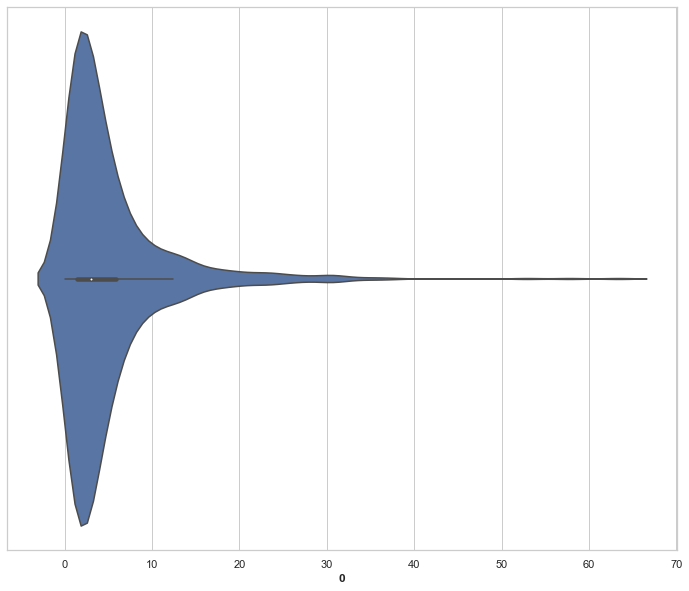

In [834]:
sns.set(style="whitegrid")
ax = sns.violinplot(x=tmpDf.loc[0])

In [812]:
RtDist_DF = pd.DataFrame(list(zip(Rt_WC, Rt_GP, Rt_KZN, Rt_Confirmed)),
              columns=['Rt_WC','RT_GP', 'Rt_KZN','Confirmed'])

In [799]:
np.mean(R0_tau,axis=1)

array([4.89126623, 4.89126568, 4.89126552, 4.89126572, 4.89126572,
       4.89126601, 4.89126485, 4.8912654 , 4.89126577])

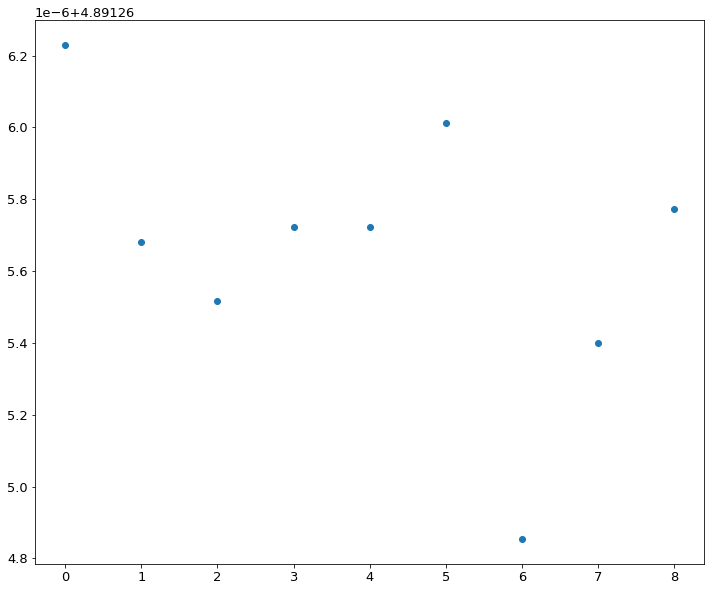

In [798]:
plt.plot(np.mean(R0_tau,axis=1),'o')

In [53]:
SA_model ={
        "R_0" : R0_SA,# calculated from data,
        "R_t" : Rt_SAfit[-1],#calculated from data,
        "t_inc" : 5.1, # Li et al. (1) has latency phase/incubation time of 5.2 days (95% CI [4.1, 7]).
        "t_inf" : 6.5,# ideally should get from data
        "t_hosp" : 4,# ideally should get from data
        "t_crit" : 14,# ideally should get from data
        "m_a" : 0.8,
        "c_a" : 0.1,
        "f_a" : 0.3
}

In [54]:
SA_model

{'R_0': 2.77319476249197,
 'R_t': 1.2908002469590283,
 't_inc': 5.1,
 't_inf': 6.5,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.1,
 'f_a': 0.3}

# Projection starts

In [74]:
DateToStartPrediction = input('Date for start of projection YYYY-MM-DD: ')

Date for start of projection YYYY-MM-DD: 2020-05-03


In [75]:
tmp = df[(df['DateReported'] == DateToStartPrediction)]# & (df['Country/Region' == 'South Africa'])]

In [76]:
MyCountry = input("Enter country to Analyse e.g 'South Arica'")

Enter country to Analyse e.g 'South Arica'South Africa


In [77]:
tmp_by_date = tmp.groupby("DateReported").sum()

In [78]:
#
# Creating a dictionary to hold data for country selected
#
UnreportedCase = 0.8 #80%
FractionExposed = 1. /(1.-UnreportedCase)
SADict = {
    "N" : SAPopulation,  # Population size
    "n_confirmed" : tmp[tmp['Country/Region'] == 'South Africa']['Confirmed'][0],
    "n_recovered" : tmp[tmp['Country/Region'] == 'South Africa']['Recovered'][1],
    "n_dead" : tmp[tmp['Country/Region'] == 'South Africa']['Dead'][2],
    "n_infected" : tmp[tmp['Country/Region'] == 'South Africa']['Confirmed'][0]-tmp[tmp['Country/Region'] == 'South Africa']['Recovered'][1],
    "n_exposed" : (tmp[tmp['Country/Region'] == 'South Africa']['Confirmed'][0]-tmp[tmp['Country/Region'] == 'South Africa']['Recovered'][1])*FractionExposed ,#thumbsuck
    "n_hosp" : 411,#from net as at 02-05-2020
    "n_crit" : 7
}

In [79]:
SADict

{'N': 59156682,
 'n_confirmed': 6783.0,
 'n_recovered': 2549.0,
 'n_dead': 131.0,
 'n_infected': 4234.0,
 'n_exposed': 21170.000000000004,
 'n_hosp': 411,
 'n_crit': 7}

## Modelling starts here


In [971]:
## Using a simple SIR model

In [1030]:
# The SIR model differential equations.
def SIR_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [1084]:
#
# Total population, N.
#
N = SADict['N']
#
# Initial number of infected and recovered individuals, I0 and R0.
#
I0, R0 = 1, 0
#
# Everyone else, S0, is susceptible to infection initially.
#
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./14. 
# A grid of time points (in days)
t = np.linspace(0, 240, 240)

In [1085]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SIR_model, y0, t, args=(N, beta, gamma))
S, I, R = ret.T


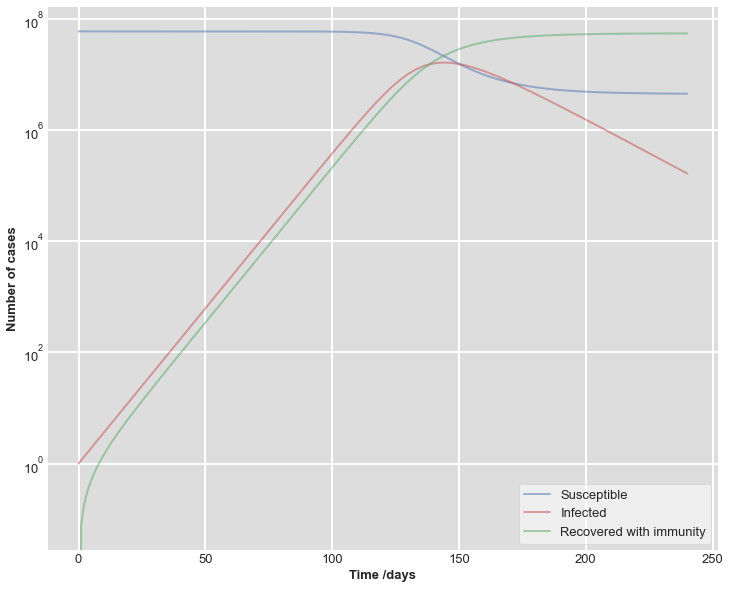

In [1086]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.semilogy()
ax.set_xlabel('Time /days')
ax.set_ylabel('Number of cases')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [1089]:
ToFitData = False

In [1094]:
if ToFitData:
    def loss(point, data):
        """
        RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
        """
        size = len(data)
        beta, gamma = point
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        solution = solve_ivp(SIR, [0, size], [S0,I0,R0], t_eval=np.arange(0, size, 1), vectorized=True)
        return np.sqrt(np.mean((solution.y[1] - data)**2))

    ToFit = SAProvinConfirmed[SAProvinConfirmed.index < datetime.strptime('Mar 27 2020', '%b %d %Y') ]['Confirmed']
    data=ToFit

    optimal = minimize(loss,
                       [59e4, 1e4],
                       args=(data),
                       method='L-BFGS-B',
                       options={'gtol': 1e-6, 'disp': True}
                      )
    #                   bounds=[(1.0e-3, 0.4), (1.0e-3, 0.4)]
    #                  )
    beta, gamma = optimal.x
    print(optimal)
    fig, ax = plt.subplots(figsize=(15, 10))
    #ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
    #ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    #ax.plot(data.values,'o')

# Using a simple SIRD model 

In [1095]:
def SIRD(y, t, N, beta, gamma, mu):
    '''
    y - inital values
    beta, gamme and mu are the rates of infection, recovery and mortality
    
    '''
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return dSdt, dIdt, dRdt, dDdt

In [1097]:
MySIRDStartDate = '2020-03-27'

In [1098]:
# Adding death numbers to the second model for SIR starting about 3/21
I0 = ConfirmedDf.Confirmed[(ConfirmedDf['Country/Region']=='South Africa') 
                           & (ConfirmedDf.index == MySIRDStartDate)].values[0]
R0 = RecoveredDf.Recovered[(RecoveredDf['Country/Region']=='South Africa') 
                           & (RecoveredDf.index == MySIRDStartDate)].values[0]
D0 = DeadDf.Dead[(DeadDf['Country/Region']=='South Africa') 
                           & (DeadDf.index == MySIRDStartDate)].values[0]

S0 = SADict['N'] - I0 - R0 - D0

t = np.linspace(0,180, 180)

beta, gamma = 1.12, 0.032  
mu = 0.012

y0 = S0, I0, R0, D0
ret = odeint(derivSIRD, y0, t, args =(SADict['N'], beta, gamma, mu))

S, I, R, D = ret.T

[]

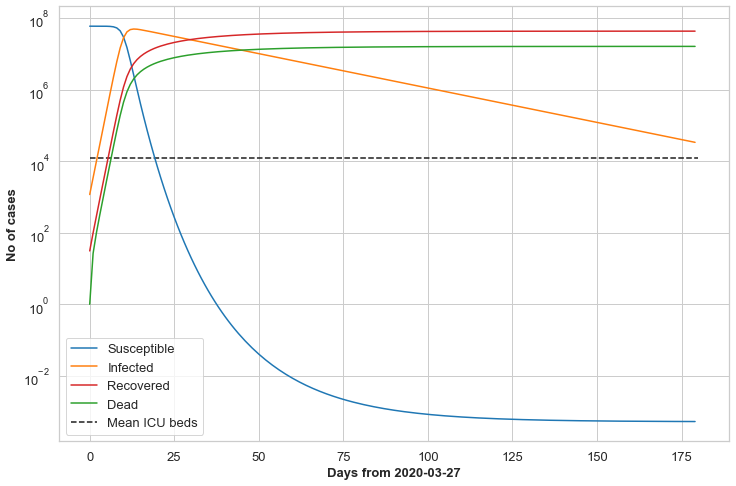

In [1099]:
plt.figure(figsize=(12,8))

#fig.suptitle(title)

plt.plot(S, 'tab:blue', label='Susceptible');
plt.plot(I, 'tab:orange', label='Infected');
plt.plot(R, 'tab:red', label='Recovered');
plt.plot(D, 'tab:green', label='Dead');
plt.xlabel(f"Days from {MySIRDStartDate}")
plt.ylabel("No of cases")
plt.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(S),linestyles='dashed',
           label="Mean ICU beds")
plt.legend()
plt.semilogy()

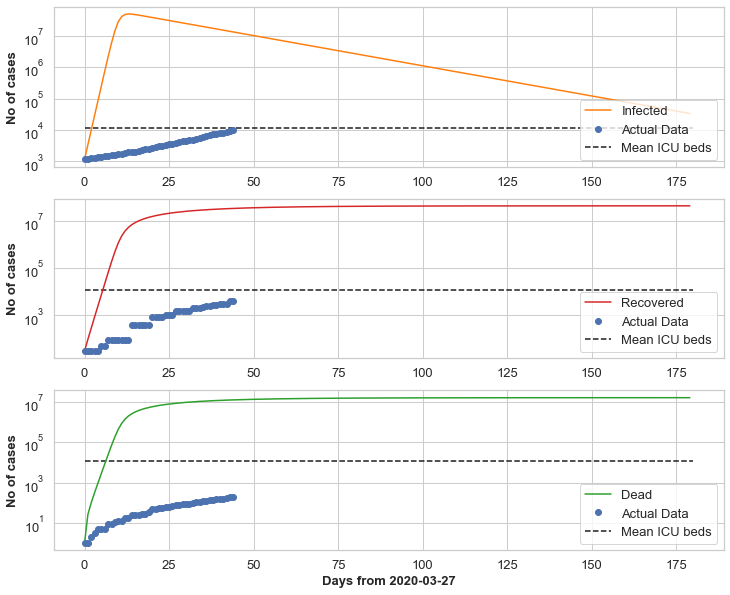

In [1100]:
fig, ax = plt.subplots(3,1)
                                
ax[0].plot(I, 'tab:orange', label='Infected');
ax[0].plot(ConfirmedDf.Confirmed[(ConfirmedDf['Country/Region']=='South Africa') 
                               & (ConfirmedDf.index >= MySIRDStartDate)].values,'o',label='Actual Data');
ax[0].hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(S),linestyles='dashed',
           label="Mean ICU beds")
ax[0].set_ylabel("No of cases")
ax[0].semilogy()
ax[0].legend(loc='lower right')

ax[1].plot(R, 'tab:red', label='Recovered');
ax[1].plot(RecoveredDf.Recovered[(RecoveredDf['Country/Region']=='South Africa') 
                               & (RecoveredDf.index >= MySIRDStartDate)].values,'o',label='Actual Data');
ax[1].hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(R),linestyles='dashed',
           label="Mean ICU beds")
ax[1].set_ylabel("No of cases")
ax[1].semilogy()
ax[1].legend(loc='lower right')

ax[2].plot(D, 'tab:green', label='Dead');
ax[2].plot(DeadDf.Dead[(DeadDf['Country/Region']=='South Africa') 
                               & (DeadDf.index >= MySIRDStartDate)].values,'o',label='Actual Data');
ax[2].hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(D),linestyles='dashed',
           label="Mean ICU beds")
ax[2].set_ylabel("No of cases")
ax[2].semilogy()
ax[2].legend(loc='lower right')

plt.xlabel(f"Days from {MySIRDStartDate}");


### Model without intervention

In [80]:
def model_no_intervention(ModelName,model_days,MyCountry,MyCountryDict):
    
    if MyCountry == "South Africa":
        #print(f"Doing {MyCountry}")
        N = MyCountryDict['N']  # Population size
        n_infected = MyCountryDict['n_infected'] # total cases - recovered: 4793 - 1473
        n_exposed = MyCountryDict['n_exposed'] #thumbsuck
        n_recovered = MyCountryDict['n_recovered']
        n_hosp = MyCountryDict['n_hosp']
        n_crit = MyCountryDict['n_crit']
        n_dead = MyCountryDict['n_dead']
        
        initial_state = [(N - n_infected)/N, n_exposed/N, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N]
    else:
        #print("Not doing my country..this is for cross checking")
        #N = int(input("Enter population size"))
        N = 100000  # Population size
        n_infected = 1
        # State at time = 0 for SEIR_HCD model
        # The numbers correspond to the number of people in each of the SEIRHCD compartments
 
        initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
        
    # State at time = 0 for SEIR_HCD model
    # The numbers correspond to the number of people in each of the SEIRHCD compartments
    # number of people in each of the SEIRHCD compartments at start of simulation
    #initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    #initial_state = [(N - n_infected)/N, n_exposed, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N]
    #
    # Put model as a list
    #
    
    args = (ModelName["R_0"], ModelName["t_inc"], ModelName["t_inf"], ModelName["t_hosp"], ModelName["t_crit"], 
            ModelName["m_a"], ModelName["c_a"], ModelName["f_a"])

    sol = solve_ivp(SEIR_HCD_model, [0, model_days], initial_state, args=args, t_eval=np.arange(model_days))

    return(sol)

In [81]:
DateToPredictFor = datetime.strptime(input("Enter Date to end prediction [YYYY-mm-dd] "), '%Y-%m-%d')

Enter Date to end prediction [YYYY-mm-dd] 2020-12-31


In [82]:
DateToStartPred = datetime.strptime(DateToStartPrediction,'%Y-%m-%d')

In [83]:
DaysToPredict = (DateToPredictFor - DateToStartPred).days
print(f"We will be predicting for {DaysToPredict} days")

We will be predicting for 242 days


Prediction started on 2020-05-03
Maximum fatalities = 9.45e+05
Maximum starts to occur at 2020-08-13


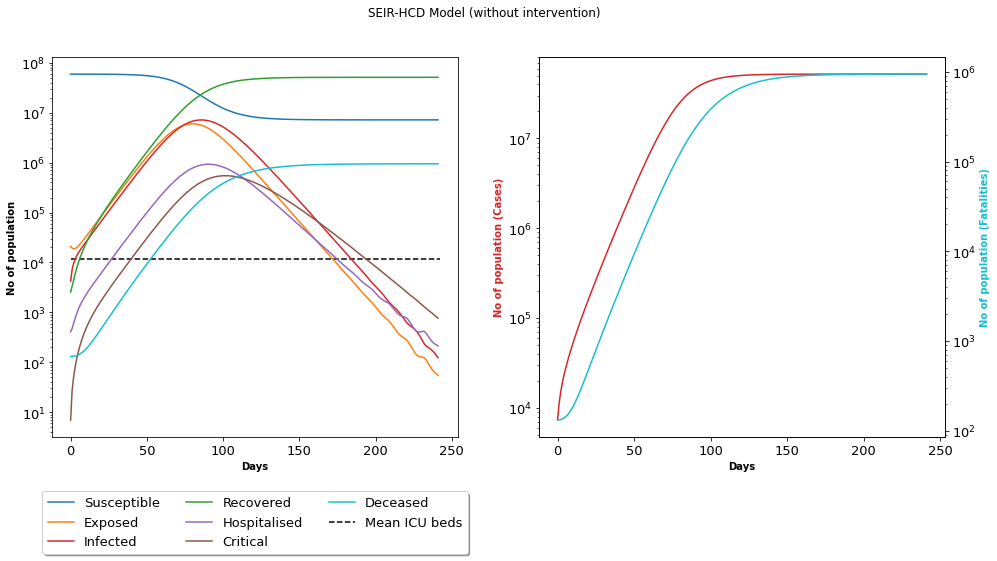

In [84]:
MyResultImperial = model_no_intervention(Imperial_model,DaysToPredict,MyCountry, SADict)

max_dead = timedelta(**{'days': int(np.gradient(MyResultImperial.y[-1]).argmax())})

print(f"Prediction started on {DateToStartPred.date()}")
print(f"Maximum fatalities = {np.max(MyResultImperial.y[-1])*SADict['N']:.3}")
print(f"Maximum starts to occur at {(datetime.strptime(DateToStartPrediction, '%Y-%m-%d')+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")

plot_model(MyResultImperial,SADict["N"], SAHospital,'SEIR-HCD Model (without intervention)')


Prediction started on 2020-05-03
Maximum fatalities = 3.25e+05
Maximum starts to occur at 2020-07-20


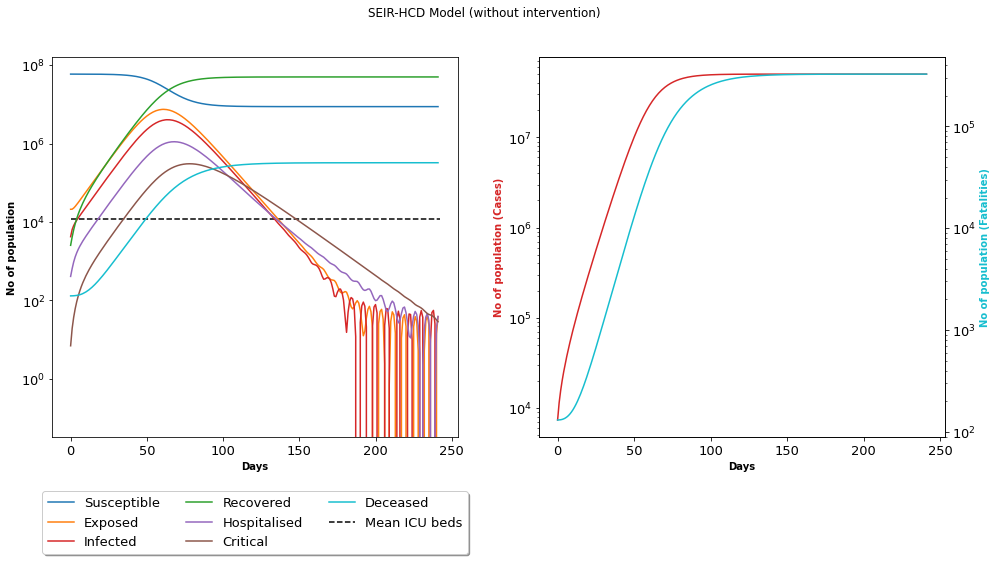

In [85]:
MyResultMidas = model_no_intervention(Midas_model,DaysToPredict,MyCountry, SADict)

max_dead = timedelta(**{'days': int(np.gradient(MyResultMidas.y[-1]).argmax())})

print(f"Prediction started on {DateToStartPred.date()}")
print(f"Maximum fatalities = {np.max(MyResultMidas.y[-1])*SADict['N']:.3}")
print(f"Maximum starts to occur at {(datetime.strptime(DateToStartPrediction, '%Y-%m-%d')+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")

plot_model(MyResultMidas,SADict["N"], SAHospital,'SEIR-HCD Model (without intervention)')



Prediction started on 2020-05-03
Maximum fatalities = 3.52e+05
Maximum starts to occur at 2020-08-29


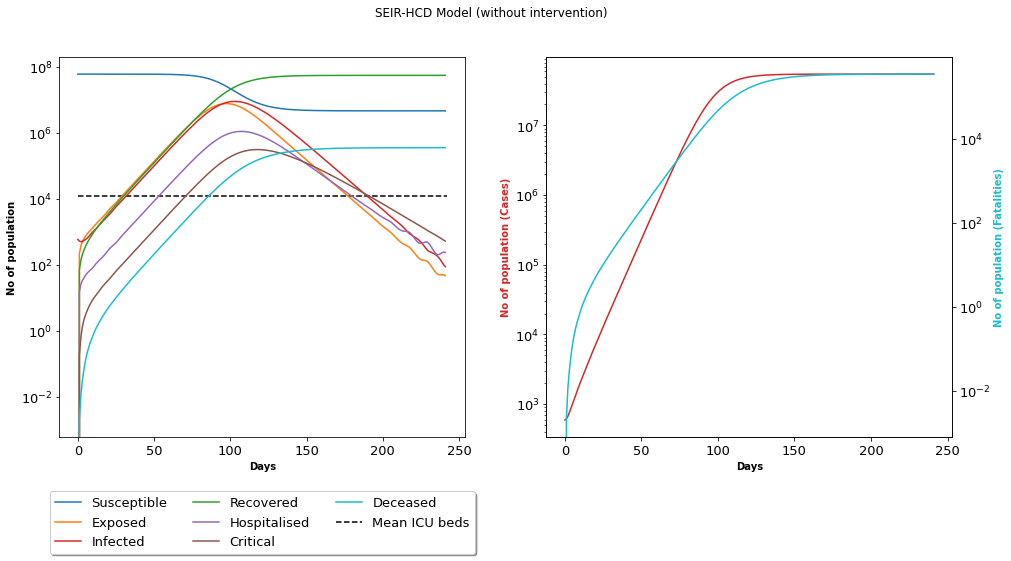

In [86]:
MyResultSA = model_no_intervention(SA_model,DaysToPredict,'lala', SADict)

max_dead = timedelta(**{'days': int(np.gradient(MyResultSA.y[-1]).argmax())})

print(f"Prediction started on {DateToStartPred.date()}")
print(f"Maximum fatalities = {np.max(MyResultSA.y[-1])*SADict['N']:.3}")
print(f"Maximum starts to occur at {(datetime.strptime(DateToStartPrediction, '%Y-%m-%d')+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")

plot_model(MyResultSA,SADict['N'], SAHospital,'SEIR-HCD Model (without intervention)')


# With intervention

In [1441]:
def model_with_intervention(ModelName,to_model_date,DateToStartPred,MyCountry,MyCountryDict,ToSample):
    '''
    Input:
        Currently based on days from 2020-05-03
        to_model_date - date to end prediction
        DateToStartPred - date to start prediction
        ToSample [Y/N] - use distribution of values
    Output:
        Solution to the ODE
    '''
    #
    # Defining the lockdown dates
    #
    L5date =  datetime.strptime('2020-03-27', '%Y-%m-%d')
    L4date =  datetime.strptime('2020-05-01', '%Y-%m-%d')
    L3date =  datetime.strptime('2020-06-01', '%Y-%m-%d')
    L2date =  datetime.strptime('2020-08-01', '%Y-%m-%d')
    #
    # Country selection here
    #
    if MyCountry == "South Africa":

        N = MyCountryDict['N']  # Population size
        n_infected = MyCountryDict['n_infected'] # total cases - recovered: 4793 - 1473
        n_exposed = n_infected*1.2 #thumbsuck
        n_recovered = MyCountryDict['n_recovered']
        n_dead = MyCountryDict['n_dead']

        n_hosp = 140
        n_crit = 70
        n_dead = 93
        
        #print(N, n_infected,n_exposed,n_recovered,n_dead)
        model_days = (to_model_date - DateToStartPred).days
        initial_state = [(N - n_infected)/N, n_exposed/N, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N]
        
    else:
        print("Not doing my country..this is for cross checking")
        #N = int(input("Enter population size"))
        N = 100000  # Population size
        n_infected = 1
        # State at time = 0 for SEIR_HCD model
        # The numbers correspond to the number of people in each of the SEIRHCD compartments
        max_days = model_days
        initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
        
    # day when lockdown start
    
    #print(f"Lockdown intervention_day starting in {intervention_day} days")


    days_to_L5 = (L5date-DateToStartPred).days
    days_to_L4 = (L4date-DateToStartPred).days
    days_to_L3 = (L3date-DateToStartPred).days
    days_to_L2 = (L2date-DateToStartPred).days
    
    if ToSample.lower() == 'n':
        R_t_L5 = 1.33
        R_t_L4 = 1.33
        R_t_L3 = 1.06
        R_t_L2 = 0.96
    else:
        R_t_L5 = 1.3
        R_t_L4 = R_t_L5*np.random.normal(1.2, 0.05) # 1.596
        R_t_L3 = R_t_L4*np.random.normal(1.2, 0.05) # 1.915
        R_t_L2 = np.minimum(0.85, np.random.normal(0.95, 0.05))

    def time_varying_reproduction(t):
        if t < days_to_L5:
            return R_0
        elif t > days_to_L5 and t < days_to_L4:
            return R_t_L5
        elif t > days_to_L4 and t < days_to_L3:
            return R_t_L4
        elif t > days_to_L3 and t < days_to_L2:
            return R_t_L3
        elif t > days_to_L2:
            return R_t_L2
        else:
            return ModelName["R_0"]

    args = (time_varying_reproduction, ModelName["t_inc"], ModelName["t_inf"], ModelName["t_hosp"], 
            ModelName["t_crit"],ModelName["m_a"], ModelName["c_a"], ModelName["f_a"])

    sol2 = solve_ivp(SEIR_HCD_model, [0, model_days], initial_state, args=args, t_eval=np.arange(model_days))
    #print(t)
    return(sol2)

Maximum fatalities = 6.16e+03


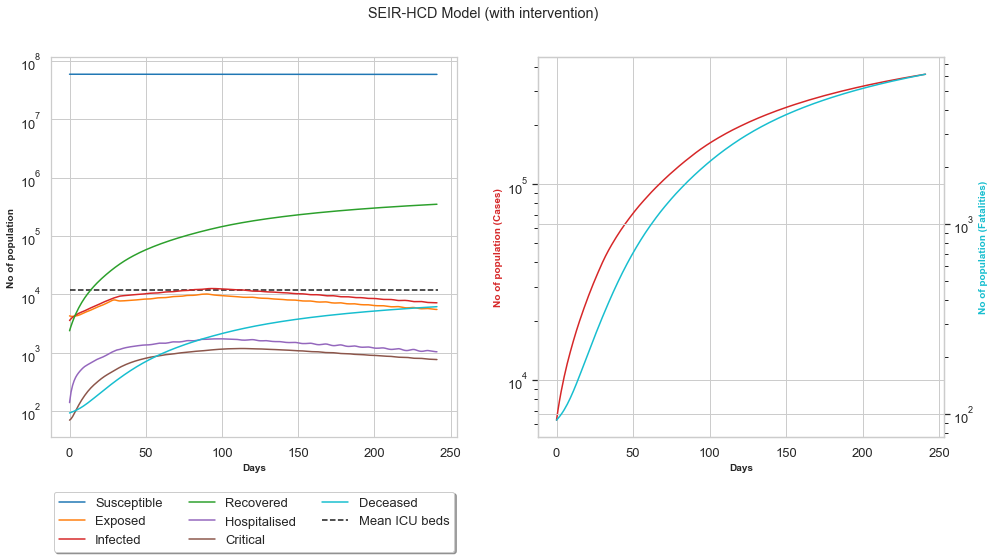

In [1442]:
StartPredictOn = datetime.strptime('2020-05-03', '%Y-%m-%d')
MyResultImperial_model2 = model_with_intervention(Imperial_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')

plot_model(MyResultImperial_model2,SADict["N"], SAHospital,f"SEIR-HCD Model (with intervention)")
print(f"Maximum fatalities = {np.max(MyResultImperial_model2.y[-1])*SADict['N']:.3}")


Maximum fatalities = 5.16e+03


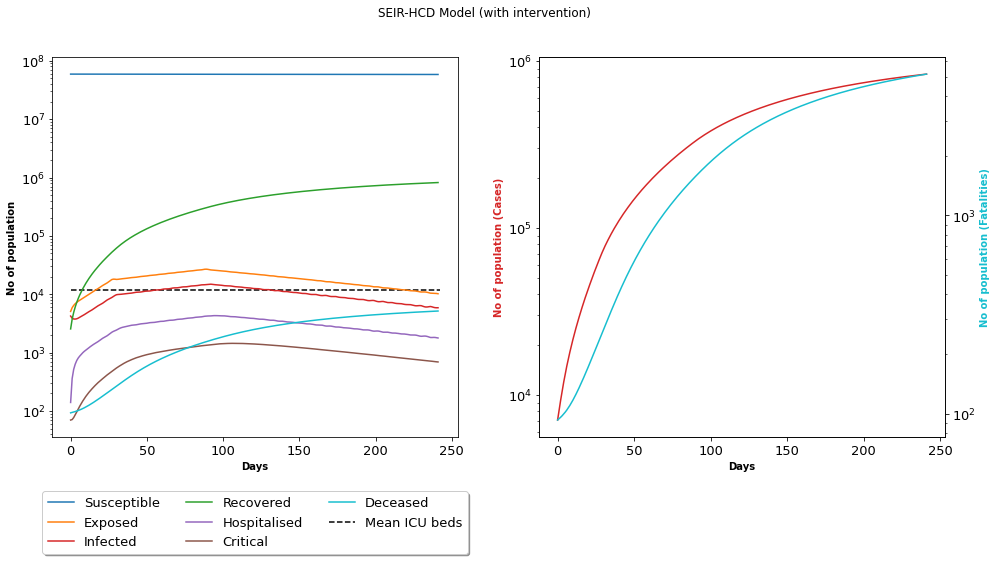

In [91]:
StartPredictOn = datetime.strptime('2020-05-03', '%Y-%m-%d')
MyResultMidas_model2 = model_with_intervention(Midas_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')

plot_model(MyResultMidas_model2,SADict["N"], SAHospital,f"SEIR-HCD Model (with intervention)")
print(f"Maximum fatalities = {np.max(MyResultMidas_model2.y[-1])*SADict['N']:.3}")


Maximum fatalities = 2.6e+03


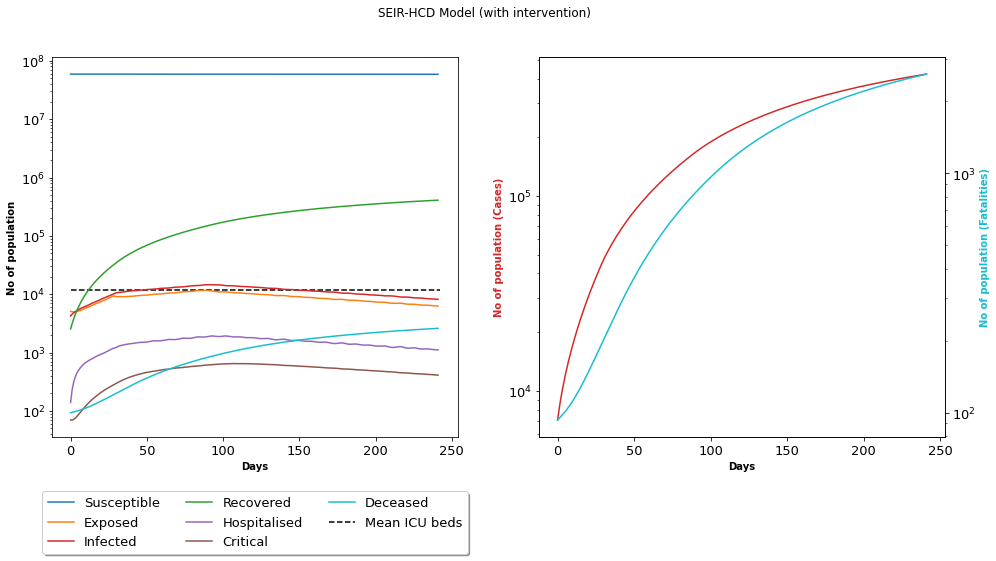

In [92]:
StartPredictOn = datetime.strptime('2020-05-03', '%Y-%m-%d')
MyResultSA_model2 = model_with_intervention(SA_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')

plot_model(MyResultSA_model2,SADict["N"], SAHospital,f"SEIR-HCD Model (with intervention)")
print(f"Maximum fatalities = {np.max(MyResultSA_model2.y[-1])*SADict['N']:.3}")


# Comparison of the two cases

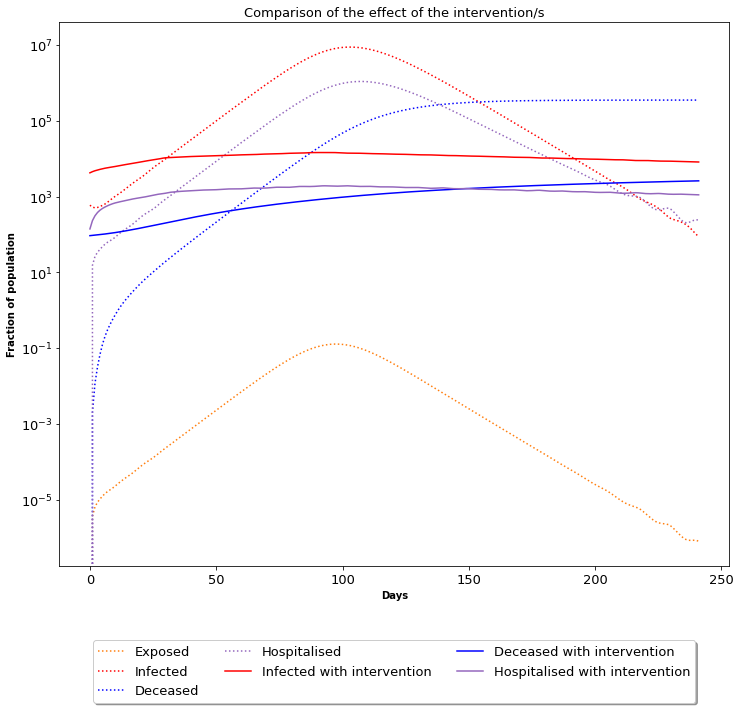

In [93]:
sus, exp, inf, rec, hosp, crit, deaths = MyResultSA.y
sus2, exp2, inf2, rec2, hosp2, crit2, deaths2 = MyResultSA_model2.y

#f = plt.figure(figsize=(8,5)) 
plt.plot(exp, 'tab:orange', label='Exposed', linestyle=':');
plt.plot(inf*SADict['N'], 'r', label='Infected', linestyle=':');
plt.plot(deaths*SADict['N'], 'b', label='Deceased', linestyle=':');
plt.plot(hosp*SADict['N'], 'tab:purple', label='Hospitalised', linestyle=':');
# plt.plot(exp2, 'tab:orange', label='Exposed with intervention');
plt.plot(inf2*SADict['N'], 'r', label='Infected with intervention');
plt.plot(deaths2*SADict['N'], 'b', label='Deceased with intervention');
plt.plot(hosp2*SADict['N'], 'tab:purple', label='Hospitalised with intervention');
plt.semilogy()
plt.title(f'Comparison of the effect of the intervention/s')
plt.xlabel("Days", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),ncol=3, fancybox=True, shadow=True);

Fitting the model to data
There are certain variables that we can play with to fit the model to real data:

* Average incubation period, t_inc
* Average infection period, t_inf
* Average hospitalization period, t_hosp
* Average critital period, t_crit
* The fraction of mild/asymptomatic cases, m_a
* The fraction of severe cases that turn critical, c_a
* The fraction of critical cases that result in a fatality, f_a
* Reproduction number, R_0 or R_t

The some of these are likely to be constants specific to the virus and some are likely to be time dependent variables dependent on factors such as:

* When a government intervened
* Peoples behaviours (do people actively self-isolate, not visit religious shrines etc.)
* Population demographic of a country (is a significant proportion of the population old?). This is the a subscript
* Heathcare system capacity (hostpital beds per capita)
* Number of testing kits available

We have already used two different reproduction numbers above. Let's see if we can derive a time-dependent R_t from the data. We will also try and optimize a handful of the parameters above to match the data.

We will also compare this to just using a single reproduction number. This might actaully be more suitable in countries where the outbreak has just started or they are struggling to limit the spread.

There are lots of ways to decay a parameter in epidemiology. I'm going to use a Hill decay, which has 2 parameters, k and L (the half decay constant):

In [1443]:
# Province data

In [1446]:
#
# Creating a dictionary to hold data for province selected
#
WCDict = {
    "N" : SAPopulation,  # Population size of WC
    "n_confirmed" : SAProvinConfirmed['Confirmed'][0],
    "n_recovered" : tmp[tmp['Country/Region'] == 'South Africa']['Recovered'][1],
    "n_dead" : tmp[tmp['Country/Region'] == 'South Africa']['Dead'][2],
    "n_infected" : tmp[tmp['Country/Region'] == 'South Africa']['Confirmed'][0]-tmp[tmp['Country/Region'] == 'South Africa']['Recovered'][1],
    "n_exposed" : (tmp[tmp['Country/Region'] == 'South Africa']['Confirmed'][0]-tmp[tmp['Country/Region'] == 'South Africa']['Recovered'][1])*FractionExposed ,#thumbsuck
    "n_hosp" : 411,#from net as at 02-05-2020
    "n_crit" : 7
}

KeyError: 'Country/Region'

In [ ]:
StartPredictOn = datetime.strptime('2020-05-03', '%Y-%m-%d')
MyResultImperial_model2 = model_with_intervention(Imperial_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')

plot_model(MyResultImperial_model2,SADict["N"], SAHospital,f"SEIR-HCD Model (with intervention)")
print(f"Maximum fatalities = {np.max(MyResultImperial_model2.y[-1])*SADict['N']:.3}")

# ** This part is still to be completed **

In [94]:
#Image(url= "https://raw.githubusercontent.com/wiki/SwissTPH/openmalaria/img/graphs/decay-functions.png")

## Checking the difference between the data and the model for infected

In [95]:
SAProvinConfirmed.index[0],SAProvinConfirmed.index[-1] 

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-05-07 00:00:00'))

In [96]:
#
# Recommend to use lockdown as the initial date
#
DateToStartModel = input('Date for start of projection YYYY-MM-DD: ')


Date for start of projection YYYY-MM-DD: 2020-05-01


In [97]:
tmp = df[(df['DateReported'] == DateToStartModel)]# & (df['Country/Region' == 'South Africa'])]

In [98]:
tmpSA = tmp[tmp['Country/Region'] == 'South Africa']

In [99]:
# Extracting data for that particular date

In [100]:
#
# Creating a dictionary to hold data for country selected
#
SADict = {
    "N" : SAPopulation,  # Population size
    "n_confirmed" : tmpSA['Confirmed'][0],
    "n_recovered" : tmpSA['Recovered'][1],
    "n_dead" : tmpSA['Dead'][2],
    "n_infected" : tmpSA['Confirmed'][0]-tmpSA['Recovered'][1],
    "n_exposed" : (tmpSA['Confirmed'][0]-tmpSA['Recovered'][1])*9 ,#thumbsuck
    "n_hosp" : 411,#from net as at 02-05-2020
    "n_crit" : 7
}

In [101]:
SADict

{'N': 59156682,
 'n_confirmed': 5951.0,
 'n_recovered': 2382.0,
 'n_dead': 116.0,
 'n_infected': 3569.0,
 'n_exposed': 32121.0,
 'n_hosp': 411,
 'n_crit': 7}

In [102]:
SA_model

{'R_0': 2.77319476249197,
 'R_t': 1.2908002469590283,
 't_inc': 5.1,
 't_inf': 6.5,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.1,
 'f_a': 0.3}

In [103]:
DateToStartModel

'2020-05-01'

In [104]:
StartPredictOn = datetime.strptime(DateToStartModel, '%Y-%m-%d')

In [107]:
WithLock = True

In [108]:
#
# we will use a lock down of 20 days
#
if WithLock:
    MyResultImperial2 = model_with_intervention(Imperial_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')
    MyResultMidas2 = model_with_intervention(Midas_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')
    MyResultSA2 = model_with_intervention(SA_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')
else:
    MyResultImperial2 = model_no_intervention(Imperial_model,DaysToPredict,MyCountry, SADict)
    MyResultMidas2 = model_no_intervention(Midas_model,DaysToPredict,MyCountry, SADict)
    MyResultSA2 = model_no_intervention(SA_model,DaysToPredict,MyCountry, SADict)

SAInfectModelImp2 = MyResultImperial2.y[2]*SADict["N"]
SAInfectModelMidas2 = MyResultMidas2.y[2]*SADict["N"]
SAInfectModelSA2 = MyResultSA2.y[2]*SADict["N"]

#
# Here selecting data from date model starts
#
SAInfectData=SAProvinConfirmed['Confirmed'][DateToStartModel:SAProvinConfirmed.index[-1]].values


ResidualModelDataImp2 = SAInfectModelImp2[0:len(SAInfectData)]-SAInfectData
ResidualModelDataMidas2 = SAInfectModelMidas2[0:len(SAInfectData)]-SAInfectData
ResidualModelDataSA2 = SAInfectModelSA2[0:len(SAInfectData)]-SAInfectData

ResidualSumSquare = [np.sum(np.square(ResidualModelDataImp2)),
                     np.sum(np.square(ResidualModelDataMidas2)),
                    np.sum(np.square(ResidualModelDataSA2))]

Model = ['Imperial', 'Midas','SA']

print(f"RSS = {np.argmin(ResidualSumSquare), min(ResidualSumSquare)}")
print(f"Best model for now is {Model[np.argmin(ResidualSumSquare)]}")

RSS = (2, 59493794.505456775)
Best model for now is SA


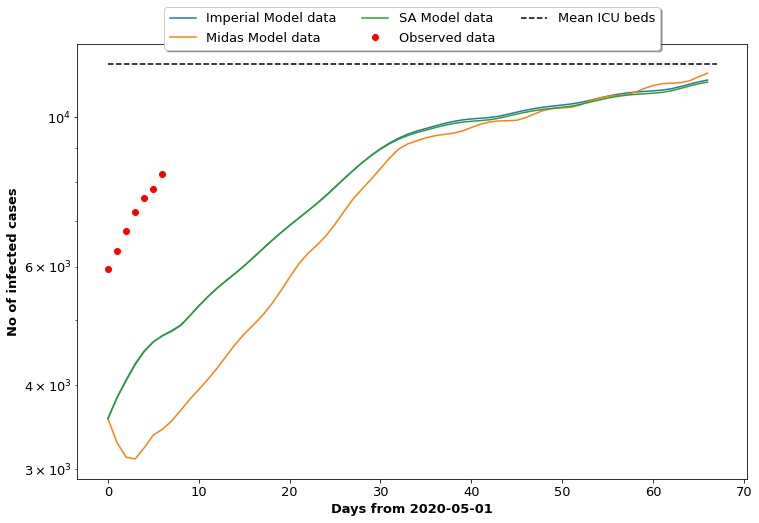

In [109]:
#
# Here I will plot the same number of days
#
plt.figure(figsize=(12,8))
plt.plot(SAInfectModelImp2[0:len(SAInfectData)+60],label="Imperial Model data")
plt.plot(SAInfectModelMidas2[0:len(SAInfectData)+60],label="Midas Model data")
plt.plot(SAInfectModelSA2[0:len(SAInfectData)+60],label="SA Model data")
plt.plot(SAInfectData,'ro',label="Observed data")
plt.hlines(MeanTotalBed,0,len(SAInfectData)+60,linestyles='dashed',label="Mean ICU beds")
plt.xlabel(f"Days from {DateToStartModel}")
plt.ylabel("No of infected cases")
plt.semilogy()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=3, fancybox=True, shadow=True);

# Checking the difference between the data and the model for infected

In [110]:
SAProvinConfirmed.index[0],SAProvinConfirmed.index[-1] 

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-05-07 00:00:00'))

In [111]:
#DateToStartModel = input('Date for start of projection YYYY-MM-DD: ')

In [112]:
print(f"We will use this date to start moelling: {DateToStartModel}")

We will use this date to start moelling: 2020-05-01


In [113]:
#
# Using the world dataset to extract data for the date modeling starting
#
tmp = df[(df['DateReported'] == DateToStartModel)]# & (df['Country/Region' == 'South Africa'])]

In [114]:
tmpSA = tmp[tmp['Country/Region'] == 'South Africa']

In [115]:
#
# Creating a dictionary to hold data for country selected
#
SADict = {
    "N" : SAPopulation,  # Population size
    "n_confirmed" : tmpSA['Confirmed'][0],
    "n_recovered" : tmpSA['Recovered'][1],
    "n_dead" : tmpSA['Dead'][2],
    "n_infected" : tmpSA['Confirmed'][0]-tmpSA['Recovered'][1],
    "n_exposed" : (tmpSA['Confirmed'][0]-tmpSA['Recovered'][1])*9 ,#thumbsuck
    "n_hosp" : 411,
    "n_crit" : 7
}



In [116]:
SADict

{'N': 59156682,
 'n_confirmed': 5951.0,
 'n_recovered': 2382.0,
 'n_dead': 116.0,
 'n_infected': 3569.0,
 'n_exposed': 32121.0,
 'n_hosp': 411,
 'n_crit': 7}

In [117]:
Imperial_model

{'R_0': 2.4,
 'R_t': 1.16,
 't_inc': 5.1,
 't_inf': 6.5,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.2,
 'f_a': 0.4}

In [120]:
WithLock = True
ToPlot = False

In [121]:
plt.figure(figsize=(12,8));
RSS = []
for R_0 in np.arange(1.0,10.,1.):
    SA_model['R_0'] = R_0
    Imperial_model['R_0'] = R_0
    Midas_model['R_0'] = R_0

    # we will use a lock down of 20 days
    #
    if WithLock:
        MyResultImperial2 = model_with_intervention(Imperial_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')
        MyResultMidas2 = model_with_intervention(Midas_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')
        MyResultSA2 = model_with_intervention(SA_model,DateToPredictFor,StartPredictOn,MyCountry, SADict,'n')
    else:
        MyResultImperial2 = model_no_intervention(Imperial_model,DaysToPredict,MyCountry, SADict)
        MyResultMidas2 = model_no_intervention(Midas_model,DaysToPredict,MyCountry, SADict)
        MyResultSA2 = model_no_intervention(SA_model,DaysToPredict,MyCountry, SADict)
   
    #print(Midas_model)
    #
    # Choosing only infected people from the model
    #
    SAInfectModelImp2 = MyResultImperial2.y[2]*SADict["N"]
    SAInfectModelMidas2 = MyResultMidas2.y[2]*SADict["N"]
    SAInfectModelSA2 = MyResultSA2.y[2]*SADict["N"]
    #
    # Here selecting data from date model starts
    #
    SAInfectData=SAProvinConfirmed['Confirmed'][DateToStartModel:SAProvinConfirmed.index[-1]].values


    ResidualModelDataImp2 = SAInfectModelImp2[0:len(SAInfectData)]-SAInfectData
    ResidualModelDataMidas2 = SAInfectModelMidas2[0:len(SAInfectData)]-SAInfectData
    ResidualModelDataSA2 = SAInfectModelSA2[0:len(SAInfectData)]-SAInfectData

    ResidualSumSquare = [np.sum(np.square(ResidualModelDataImp2)),
                         np.sum(np.square(ResidualModelDataMidas2)),
                        np.sum(np.square(ResidualModelDataSA2))]

    Model = ['Imperial', 'Midas','SA']
    
    #print(f"RSS = {np.argmin(ResidualSumSquare), min(ResidualSumSquare)}")
    #print(f"Best model for now is {Model[np.argmin(ResidualSumSquare)]}, with {min(ResidualSumSquare)}")
    RSS.append((R_0,ResidualSumSquare))
    if ToPlot:
        #
        # Here I will plot the same number of days
        #
        plt.plot(SAInfectModelImp2[0:len(SAInfectData)+120],'r',label=f"R_0={R_0}")
        plt.plot(SAInfectModelMidas2[0:len(SAInfectData)+120],'b',label="Midas Model data");
        #plt.plot(SAInfectModelSA2[0:len(SAInfectData)+120],'g',label="SA Model data")
        plt.semilogy()

        plt.plot(SAInfectData,'ko',label="Observed data")
        plt.hlines(MeanTotalBed,0,len(SAInfectData)+120,linestyles='dashed',label="Mean ICU beds")
        plt.xlabel(f"Days from {StartPredictOn}")
        plt.ylabel("No of infected")
        plt.title(f"Model with various R_0")
        plt.legend(loc='best')#, bbox_to_anchor=(0.5, 1.1),ncol=3, fancybox=True, shadow=True);
        plt.show()


<Figure size 864x576 with 0 Axes>

In [122]:
RSSDf = pd.DataFrame(RSS, columns={"R_0","RSS_value"})

In [123]:
RSSDf.loc[RSSDf['R_0'].values.argmin()]

RSS_value                                                    3
R_0          [59429459.91207987, 106465229.11400817, 594279...
Name: 2, dtype: object

# For sampling use the following

In [130]:
#
# sampling 
# 
# Creating a 95% confidence interval:
# np.percentile(means, 2.5), np.percentile(means, 97.5)
#

#
# Gamma distribution(shape k, scale theta)
# Mean = k*theta
# std =  sqrt(k)*theta
#

In [131]:

shape, scale = 2.77, 2.  # mean=2.77, std=2*sqrt(2)
s = np.random.gamma(shape, scale, 100)

In [132]:
s.mean(), np.median(s)

(4.94504110766656, 4.170131784606605)

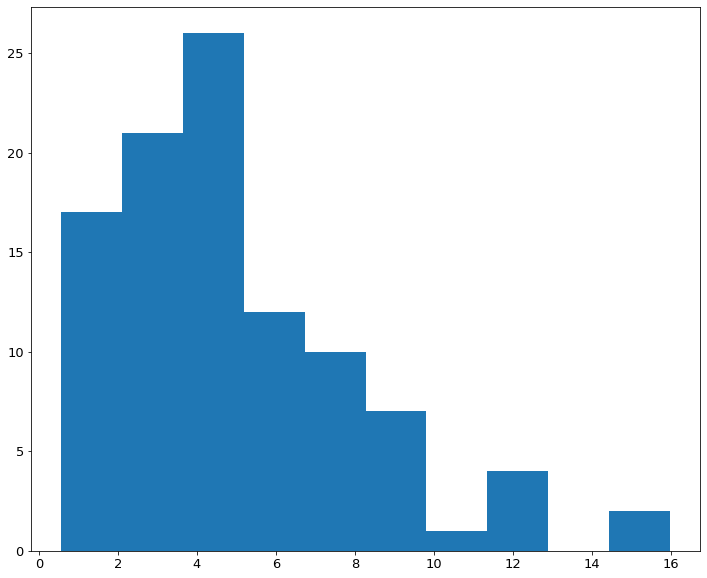

In [133]:
plt.hist(s);

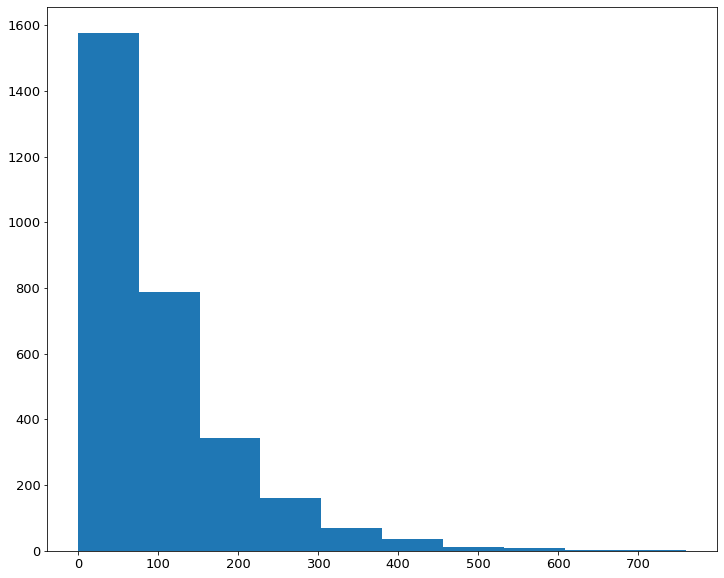

In [134]:
R0_data = np.random.gamma(1,100,3000)
plt.hist(R0_data);


# Without intervention parameters sampled from distributions

In [135]:
# Uncomment to change the population no
'''SADict = {'N': 59156682,
 'n_confirmed': 7572.0,
 'n_crit': 70,
 'n_dead': 93,
 'n_exposed': 11628.0,
 'n_hosp': 140,
 'n_infected': 9690,
 'n_recovered': 2746.0}'''

"SADict = {'N': 59156682,\n 'n_confirmed': 7572.0,\n 'n_crit': 70,\n 'n_dead': 93,\n 'n_exposed': 11628.0,\n 'n_hosp': 140,\n 'n_infected': 9690,\n 'n_recovered': 2746.0}"

In [136]:
StartPredictOn = datetime.strptime('2020-05-03', '%Y-%m-%d')

In [1103]:

# Distributions over parameters
# Parameters defined as probability distributions
# Initial conditions
NoIteration = 500
t_max = DaysToPredict
comparts = 7
multi_sols = np.zeros((NoIteration,comparts,DaysToPredict))

for i in range(NoIteration):
    Imperial_model_dist ={
        # use parameters from the Imperial paper (https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)
        "R_0" : np.maximum(1.8,np.random.normal(2.7,0.3)),
        "R_t" : np.random.normal(1.3,0.4),  #0.7, # since there is no peer reviewed R_t
        "t_inc" : np.random.normal(3.96,0.3),
        "t_inf" :  np.random.normal(6.5,2),
        "t_hosp" :  np.random.normal(4,0.5),
        "t_crit" :  np.random.normal(10,2),
        "m_a" :  np.random.normal(0.85,0.05),
        "c_a" :  np.random.normal(0.2,0.05),
        "f_a" :  np.random.normal(0.2,0.05),
}
    
    #MyResultSA2 = model_with_intervention(SA_model,DateToPredictFor,StartPredictOn,MyCountry, SADict)
    MyResultImperial = model_with_intervention(Imperial_model,DateToPredictFor,StartPredictOn,MyCountry,SADict,'y')
    multi_sols[i] = MyResultImperial.y


In [1104]:
multi_sols.shape

(500, 7, 242)

In [1105]:
ToPlot = False

In [1106]:
if ToPlot:
    #Plotting
    TotalPopulation = SADict['N']
    title='SEIR+HCD model'

    #Population = True
    for i in np.arange(0,it,int(multi_sols.shape[0]/5)):
        sus, exp, inf, rec, hosp, crit, death = multi_sols[i]*TotalPopulation
        cases = inf + rec + hosp + crit + death

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
        fig.suptitle(title)
        ax1.plot(sus, 'tab:blue', label='Susceptible');
        ax1.plot(exp, 'tab:orange', label='Exposed');
        ax1.plot(inf, 'tab:red', label='Infected');
        ax1.plot(rec, 'tab:green', label='Recovered');
        ax1.plot(hosp, 'tab:purple', label='Hospitalised');
        ax1.plot(crit, 'tab:brown', label='Critical');
        ax1.plot(death, 'tab:cyan', label='Deceased');
        ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
                    label="Mean ICU beds")

        y1 = SAHospital[1][0]
        y2 = SAHospital[1][1]
        ax1.axhspan(y1, y2, facecolor='k', alpha=0.5)
            #ax1.fill_between(len(sus), y1,y2,alpha=0.5)

        ax1.semilogy()

        ax1.set_xlabel("Days", fontsize=10);
        ax1.legend(loc='best');
        ax2.plot(cases, 'tab:red', label='Cases');    
        ax2.set_xlabel("Days", fontsize=10);
        ax2.semilogy()

        ax3 = ax2.twinx()
        ax3.plot(death, 'tab:cyan', label='Deceased');    
        ax3.set_xlabel("Days", fontsize=10);
        ax3.semilogy()

        ax1.set_ylabel("No of population", fontsize=10);
        ax2.set_ylabel("No of population (Cases)", fontsize=10, color='tab:red');
        ax3.set_ylabel("No of population (Fatalities)", fontsize=10, color='tab:cyan');
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),ncol=3, fancybox=True, shadow=True)
        print(f"Maximum fatalities = {np.max(multi_sols[i][-1])*SADict['N']:.3}")
        max_dead = timedelta(**{'days': int(np.gradient(multi_sols[i][-1]).argmax())})
        print(f"Maximum starts to occur at {(StartPredictOn+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")


# Plotting the mean values 

Maximum fatalities = 2.19e+05
Maximum starts to occur at 2020-08-24


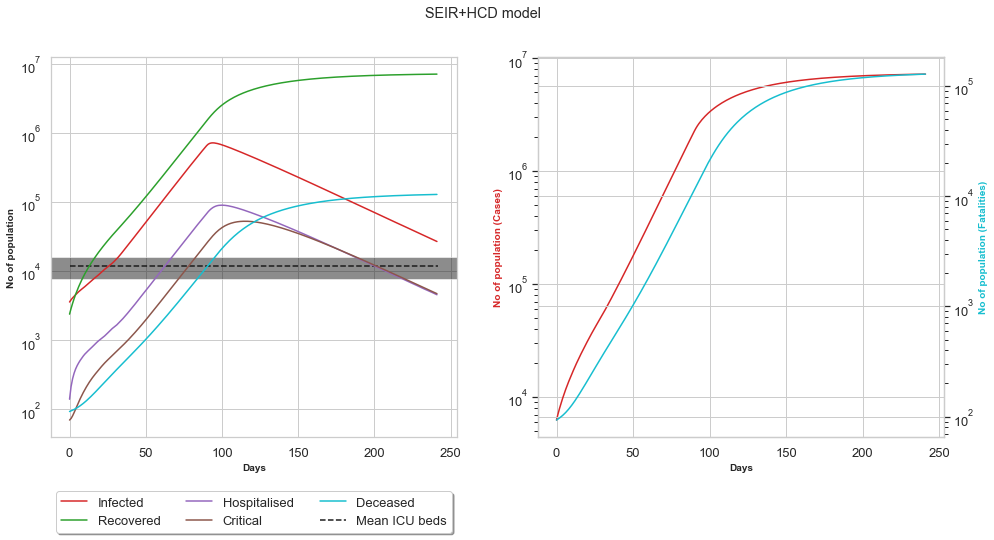

In [1107]:

TotalPopulation = SADict['N']
title='SEIR+HCD model'
        
#Population = True

sus, exp, inf, rec, hosp, crit, death = np.mean(multi_sols,axis=0)*TotalPopulation
cases = inf + rec + hosp + crit + death
      
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
fig.suptitle(title)
#ax1.plot(sus, 'tab:blue', label='Susceptible');
#ax1.plot(exp, 'tab:orange', label='Exposed');
ax1.plot(inf, 'tab:red', label='Infected');
ax1.plot(rec, 'tab:green', label='Recovered');
ax1.plot(hosp, 'tab:purple', label='Hospitalised');
ax1.plot(crit, 'tab:brown', label='Critical');
ax1.plot(death, 'tab:cyan', label='Deceased');
ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
              label="Mean ICU beds")

y1 = SAHospital[1][0]
y2 = SAHospital[1][1]
ax1.axhspan(y1, y2, facecolor='k', alpha=0.5)
#ax1.fill_between(len(sus), y1,y2,alpha=0.5)
        
ax1.semilogy()

ax1.set_xlabel("Days", fontsize=10);
ax1.legend(loc='best');
ax2.plot(cases, 'tab:red', label='Cases');    
ax2.set_xlabel("Days", fontsize=10);
ax2.semilogy()

ax3 = ax2.twinx()
ax3.plot(death, 'tab:cyan', label='Deceased');    
ax3.set_xlabel("Days", fontsize=10);
ax3.semilogy()

ax1.set_ylabel("No of population", fontsize=10);
ax2.set_ylabel("No of population (Cases)", fontsize=10, color='tab:red');
ax3.set_ylabel("No of population (Fatalities)", fontsize=10, color='tab:cyan');
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),ncol=3, fancybox=True, shadow=True)
print(f"Maximum fatalities = {np.max(multi_sols[i][-1])*SADict['N']:.3}")
max_dead = timedelta(**{'days': int(np.gradient(multi_sols[i][-1]).argmax())})
print(f"Maximum starts to occur at {(StartPredictOn+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")


In [1108]:
sus_mean, exp_mean, inf_mean, rec_mean, hosp_mean, crit_mean, death_mean = np.mean(multi_sols,axis=0)*TotalPopulation
sus_std, exp_std, inf_std, rec_std, hosp_std, crit_std, death_std = np.std(multi_sols,axis=0)*TotalPopulation


In [1109]:
x = np.arange(0,len(inf_mean))
y_est = inf_mean
y_err = inf_std

Maximum infected = 7.15e+05
Lower Maximum infected = 3.57e+03
Upper Maximum infected = 1.08e+06
Turn overstarts to occur at 2020-08-05


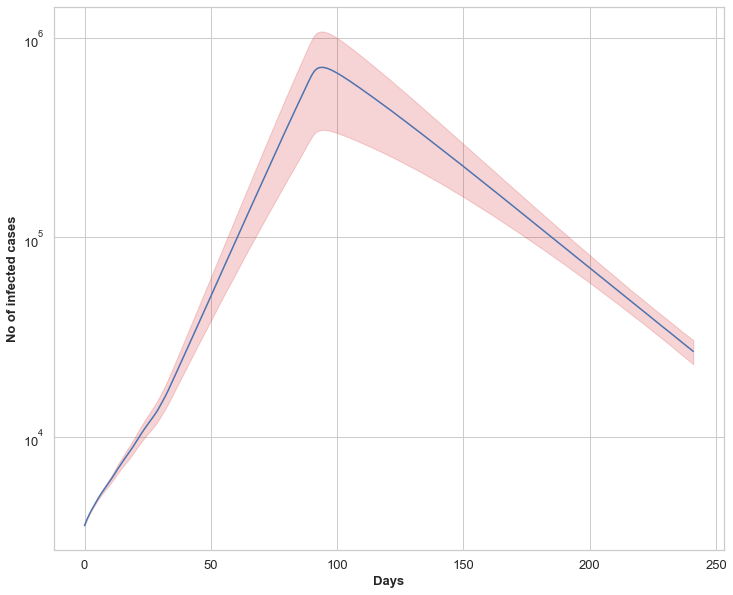

In [1110]:
fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2,color='tab:red')
ax.semilogy()
ax.set_xlabel('Days')
ax.set_ylabel('No of infected cases')
print(f"Maximum infected = {np.max(y_est):0.3}")
print(f"Lower Maximum infected = {np.min(y_est-y_err):0.3}")
print(f"Upper Maximum infected = {np.max(y_est+y_err):0.3}")
turn_over = timedelta(**{'days': int(int(y_est.argmax()))})
print(f"Turn overstarts to occur at {(datetime.strptime('2020-05-03', '%Y-%m-%d')+timedelta(days=turn_over.days)).strftime('%Y-%m-%d')}")


Text(0, 0.5, 'No of critical cases')

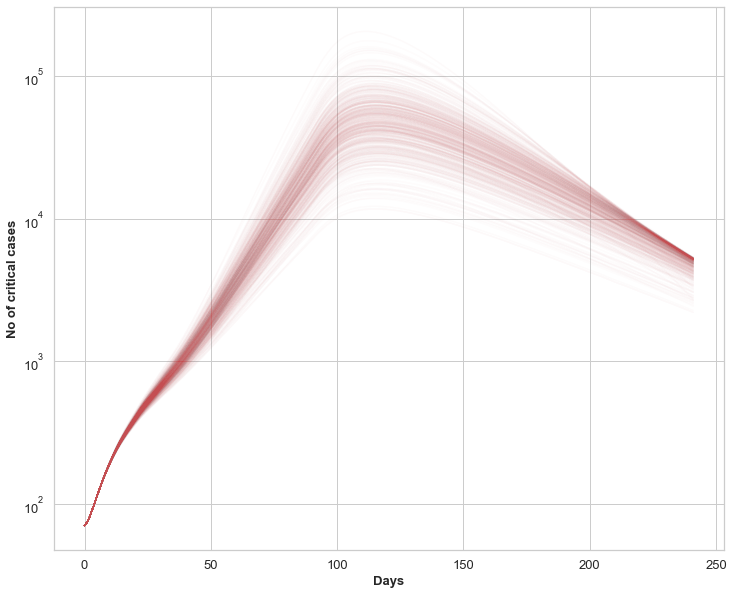

In [1111]:
Alpha = np.linspace(0.01,0.025,multi_sols.shape[0])
#sus, exp, inf, rec, hosp, crit, death = np.mean(multi_sols,axis=0)*TotalPopulation
for i in range(multi_sols.shape[0]):
    plt.plot(multi_sols[i][5]*TotalPopulation,"r",alpha= Alpha[i])
plt.semilogy()
plt.xlabel('Days')
plt.ylabel('No of critical cases')

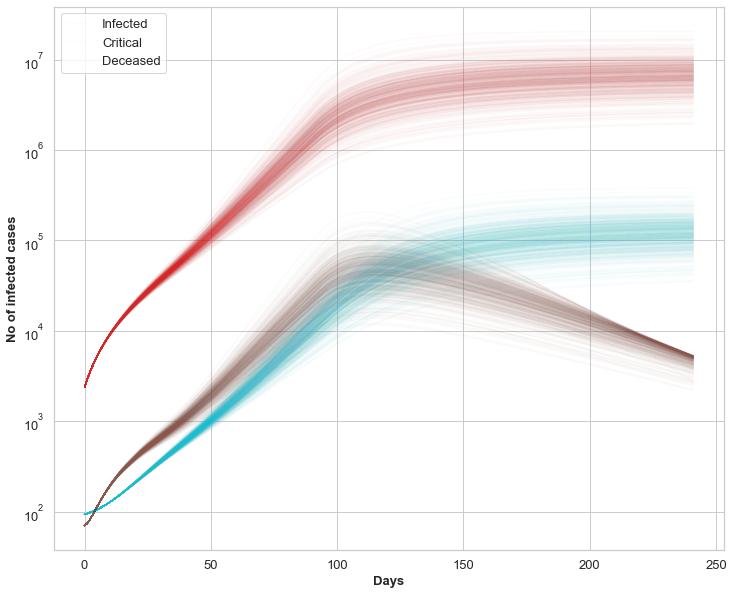

In [1112]:
Alpha = np.linspace(0.01,0.025,multi_sols.shape[0])
#sus, exp, inf, rec, hosp, crit, death = np.mean(multi_sols,axis=0)*TotalPopulation
for i in range(multi_sols.shape[0]):
    plt.plot(multi_sols[i][3]*TotalPopulation,alpha= Alpha[i],color='tab:red', label='Infected');
    plt.plot(multi_sols[i][5]*TotalPopulation,alpha= Alpha[i],color='tab:brown', label='Critical');
    plt.plot(multi_sols[i][6]*TotalPopulation,alpha= Alpha[i],color='tab:cyan', label='Deceased');
plt.semilogy()
plt.xlabel('Days')
plt.ylabel('No of infected cases')
plt.legend(["Infected","Critical","Deceased"]);